In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from gym import Env
from tqdm.notebook import tqdm
import torch
from PIL import Image

# **map**

In [2]:
def map():

  #0: regular state, 1: agent ,2: zarbdar, 3; Almas , 4: Start_state, 5: Goal_state, 6:divar

  map = np.zeros([25,25])

  ALMAS = [(24,10),(24,18),(23,24),(22,20),(21,19),(20,2),(20,5),(20,11),(20,22),
          (19,3),(17,1),(13,11),(14,13),(14,17),(13,20),(13,23),(11,22),(11,0),
          (11,5),(11,6),(7,7),(6,17),(4,14),(1,1),(1,6),(1,17),(0,7),(0,20),(1,10)]


  zarbdar = [(0,10),(0,11),(0,12),(0,13),(0,14),(1,12),(6,0),(6,1),(6,2),(6,3),(6,4),(7,0),(7,1),(7,2),(8,0),(8,1),
          (8,4),(9,4),(10,4),(9,3),(9,2),(10,2),(10,1),(11,1),(11,0),(20,14),(21,14),(22,15),(22,16),(18,16),
          (17,16),(17,15),(17,17),(19,19),(19,20),(20,20),(21,19),(22,19),(5,8),(6,8),
          (5,9),(6,9),(8,11),(9,11),(8,12),(9,12),(11,5),(11,6)]


  # zarbdar
  for i in range(0,6):
    for j in range(0,6):
      map[i][j] = 2

  for i in range(7,11):
    for j in range(5,11):
      map[i][j] = 2

  for i in range(19,22):
    for j in range(15,19):
      map[i][j] = 2

  for i,j in zarbdar:
    map[i][j] = 2

  for i,j in ALMAS:
    map[i][j] = 3

  #start point
  map[24][16] = 4
  #end point
  map[3][6] = 5



  ax = sns.heatmap( map , linewidth = 0.5 , cmap = 'coolwarm', cbar=False )
  ax.axis('off')
  plt.show()

  return map

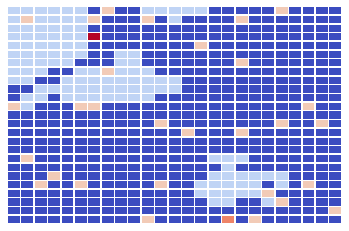

In [3]:
MYMAP = map()

# parameters

In [4]:
WINSTATE = (3, 6)
START_STATE = (24, 16)
GOALREWARD = 1000
ZARBDAR_REWARD = -1000
STEP_REWARD = -10
ALMAS_REWARD = 350
NEW_STATE = 100
ROWS = 25
COLS = 25
#up-left = 0, up = 1, up-right = 2, left = 3,right = 4, down-left = 5, down = 6, down-right =7
ACTION_SPACE = [0, 1, 2, 3 , 4, 5, 6, 7] 

#almas
ALMAS = [(24,10),(24,18),(23,24),(22,20),(21,19),(20,2),(20,5),(20,11),(20,22),
          (19,3),(17,1),(13,11),(14,13),(14,17),(13,20),(13,23),(11,22),(11,0),
          (11,5),(11,6),(7,7),(6,17),(4,14),(1,1),(1,6),(1,17),(0,7),(0,20),(1,10)]

ZARBDAR = [(0,10),(0,11),(0,12),(0,13),(0,14),(1,12),(6,0),(6,1),(6,2),(6,3),(6,4),(7,0),(7,1),(7,2),(8,0),(8,1),
          (8,4),(9,4),(10,4),(9,3),(9,2),(10,2),(10,1),(11,1),(11,0),(20,14),(21,14),(22,15),(22,16),(18,16),
          (17,16),(17,15),(17,17),(19,19),(19,20),(20,20),(21,19),(22,19),(1,8),(2,8),(4,8),(5,8),(6,8),
          (4,9),(5,9),(6,9),(8,11),(9,11),(8,12),(9,12),(11,5),(11,6)]


In [5]:
class Mars(Env):
    def __init__(self, action_space, env_map, prob_transition = 0.94): # 

        x = 24
        y = 16
    
        self.action_space = action_space
        self.env_map = env_map
        self.state = (x,y)
        self.isEnd = False
        self.prob_transition = prob_transition
        self.fail_reward = -11
        self.current_map = env_map
        self.map_with_robot = env_map
        
        self.stored_state = []
   
    def reset(self):
        
        return START_STATE
    
    def state_reward(self, state):
        count = 0
        states = self.possible_states(state)  
        for s in states:
          if s in self.stored_state:
              pass
          else:
              count += 1
          
        return count

    def getReward(self, state):
        total_reward = self.state_reward(state)
        if state == WINSTATE: # Rward at win state is 100
            total_reward +=  GOALREWARD
        elif state in ZARBDAR :   # Reward for failing in any hole is -10 ie punishment
            total_reward += ZARBDAR_REWARD
        elif state in ALMAS:
            total_reward += ALMAS_REWARD
        else:                            # Reward for each transition to a non terminal state is -1
            total_reward += STEP_REWARD
      
        return total_reward
    def isGoal(self, state):
        if (self.state == WINSTATE):
            self.isEnd = True
        return self.isEnd

    def NextStateFunc(self,state , action):  #up-left = 0, up = 1, up-right = 2, left = 3,right = 4, down-left = 5, down = 6, down-right =7
        if action == 0:
            nextState = (state[0] - 1, state[1] - 1)

        elif action == 1:
            nextState = (state[0] - 1, state[1])

        elif action == 2:
            nextState = (state[0] - 1, state[1] + 1)

        elif action == 3:                
            nextState = (state[0] , state[1] - 1)   
        
        elif action == 4:                
            nextState = (state[0] , state[1] + 1 )  

        elif action == 5:                
            nextState = (state[0] + 1, state[1] - 1) 

        elif action == 6:                
            nextState = (state[0] + 1 , state[1]) 

        elif action == 7:                
            nextState = (state[0] + 1, state[1] + 1)   

        else :
          print("We don't have this action in our action space")             
        
        
        if (nextState[0] >= 0) and (nextState[0] <= ROWS-1):
            if (nextState[1] >= 0) and (nextState[1] <= COLS-1):                    
                    return nextState # if next state legal
        return state # Any move off the grid leaves state unchanged

    def out_of_gird(self, state):

        if (state[0] >= 0) and (state[0] <= ROWS-1):
            if (state[1] >= 0) and (state[1] <= COLS-1):                    
                    return False # if next state legal
        return True # Any move off the grid leaves state unchanged


    def possible_states(self, state): # a function for returning possible next state
        
        states = []
        for action in range(len(self.action_space)): # left = 0, down = 1, right = 2, up = 3
            states.append(self.NextStateFunc(state, action))
        return states


    
    def prob_h(self, state):
        
        return MYMAP[state[0]][state[1]]

    def prob_transition_func(self, state, action):
        
        n = len(self.action_space)
        prob = np.ones(n)* (1-self.prob_transition)/(n-1)
        prob[action] = self.prob_transition

        if state in ZARBDAR:# if state in zarbdar list the transition probability will be zero
          prob = np.zeros(n)
          
        if state == WINSTATE:# if we are in Winstate the transition probability is zero
          prob = np.zeros(n)

        return prob
        
    def state_probablity_func(self, state, action):
        rewards = []
        height_prob = []
        result = [] #a list of tuple ()

        states = self.possible_states(state)    
        transitions_prob = self.prob_transition_func(state, action)


        for s in states:
          rewards.append(self.getReward(s))
          height_prob.append(self.prob_h(s))
        
        for i in range(len(states)):
            result.append((states[i], transitions_prob[i],rewards[i], height_prob[i]))

        return result

    def observation(self, state):
        obs = np.zeros([3*3]) #0: regular state, 1: agent ,2: zarbdar, 3; Almas , 4: Start_state, 5: Goal_state, 6:divar
        list_state = self.possible_states(state)
        i = 0
        m_state = np.zeros([9])
        for s in list_state:
          #print(i)
          if i == 4:
            m_state[i] = 1
            i +=1
            #print(i)
          elif s in ALMAS:
            #print(3)
            m_state[i] = 3
          elif s in ZARBDAR:
            #print(2)
            m_state[i] = 2
          elif s == START_STATE:
            #print(4)
            m_state[i] = 4
          elif s == WINSTATE:
            #print(5)
            m_state[i] = 5
          elif self.out_of_gird(state):

            m_state[i] = 6
          i +=1
        #np.reshape(m_state, (3, 3))
        return m_state
    
    def explores_states(self, state):

        states = self.possible_states(state) 
        for s in states:
          if s in self.stored_state:
            pass
          else:
            self.stored_state.append(s)

    def step(self,state, action): #next_state, reward, terminated, truncated, info 
        """
        Perform an action to the environment, provide observation for the new state and provide a reward
        
        :param 1:selected action 

        :return: the next state of the env, the reward of the action, and whether the episode is finished
        """
        
        next_state = self.NextStateFunc(state, action)
        self.state = next_state

        reward = self.getReward(state)
        end_state = self.isGoal(state)
        self.explores_states(state)
        
        return next_state, reward, end_state



    def render_reset(self):
        self.map_with_robot = self.env_map.copy()
        self.current_map = self.env_map.copy()

    def render(self):
      #0: regular state, 1: agent ,2: zarbdar, 3; Almas , 4: Start_state, 5: Goal_state, 6:divar

        self.map_with_robot = self.current_map.copy()

        print("render_agent_position :", self.state)
        x_current , y_current = self.state
        if self.current_map[x_current][y_current] == 3 :#almas
            self.current_map[x_current][y_current] = 0

        self.map_with_robot[x_current][y_current] = 1
        ax = sns.heatmap(self.map_with_robot , linewidth = 0.5 , cmap = 'coolwarm', cbar=False )
        ax.axis('off')

        
        plt.show()  

        return self.map_with_robot
        

    def close(self): 
        """
        (Optional) : Perform cleanup

        """
  

# **q-learning agent** 

In [15]:
class Agent_Q:
    def __init__(self, episods = 1, alpha = 0.1,gamma = 0.9, eps = 0.1, lr_cons = True, runs = 1 ):
        
        self.alpha = alpha
        self.episods = episods
        self.eps = eps
        self.n_state = 25 * 25
        self.n_action = len(ACTION_SPACE)
        self.Q_value = np.zeros([25, 25, self.n_action])
        self.G = 0
        self.lr_cons = lr_cons
        self.reward_sum = []
        self.reward_mean = []
        self.Q_value_mean = []
        self.runs = runs
        self.gamma = gamma
        self.max_step = 500

    def update_eps(self, k):
        max_eps = 1.0
        min_eps = 0.02
        decay_rate = 0.005
        #self.eps = 100/(100+k)
        self.eps = min_eps + (max_eps - min_eps)*np.exp(-decay_rate*k)
     
    def update_alpha(self, k):
        max_alpha = 0.9
        min_alpha = 0.01
        decay_rate = 0.005
        if self.lr_cons == False:
            self.alpha = min_alpha + (max_alpha - min_alpha)*np.exp(-decay_rate*k)
    
    def take_action(self, state, k):

        x, y = state
        policy = [np.argmax(self.Q_value[x, y]), np.random.randint(0, self.n_action) ] #policy
        #print(policy)
        action = np.random.choice(policy, 1, p=[ (1-self.eps), self.eps])#eps = random, 1-eps = argmax
        #print(action)
        return action[0]
        #return np.argmax(self.Q_value[state])
    
    def update(self, state,next_state, action, reward):

        x, y = state
        nx, ny = next_state
      
        self.Q_value[x, y][action] = self.Q_value[x, y][action] + self.alpha * (reward + self.gamma * np.max(self.Q_value[nx, ny]) - self.Q_value[x, y][action]) #behavior policy
        self.G += reward

        
    def q_learning(self):

        for episod in range(self.episods):
            terminated = False
            self.G, reward = 0, 0
            #env.render()
            state = env.reset()
            #env.render_reset()
            #update epsilon
            self.update_eps(episod)
            self.update_alpha(episod)
            #print(self.alpha)
            first_state = state
            rewards = []
            step = 0
            #print("episode :" ,episod)
            render_list = []
            for step in range(self.max_step):
                
                
                action = self.take_action(state, episod)
                
                #render_list.append(step_render)
                #
                next_state, reward, terminated = env.step(state, action)
                #
                rewards.append(reward)
                self.update(state, next_state, action, reward)
                '''if step % 200 == 0:
                  print("step :",step)
                  print("action :",action)
                  print("state:", state, "__ action:")
                  print("next_state :", next_state)
                  step_render = env.render()'''
                if terminated:
                  break
                state = next_state
            
          
            self.reward_sum.append(np.sum(rewards))
            self.reward_mean.append(np.mean(rewards))
        return self.reward_sum, self.reward_mean, self.Q_value, render_list

    def n_runs(self):
        n_rewards = []
        n_Q_values = []
        
        for i in tqdm(range(self.runs)):
            
            self.reward_sum = []
            self.reward_mean = []
            self.Q_value = np.zeros([25, 25, self.n_action])
            sum_rewards, mean_rewards, mean_Q_value, render_list = self.q_learning()
            n_rewards.append(sum_rewards)
            n_Q_values.append(mean_Q_value)
        return np.mean(np.array(n_rewards),axis =0), np.mean(np.array(n_Q_values),axis =0)


In [16]:
env = Mars(ACTION_SPACE, MYMAP, 0.94)  # action_space, env_map, prob_transition = 0.94
num_episode = 1000
num_rus = 5
agent_q = Agent_Q(num_episode, 0.1, 0.9,0.1, True,num_rus) #episods, alpha=lr, gamma=discoutn_factor, eps, lr_cons, runs
mrq1, mqv1 = agent_q.n_runs()
#0: regular state, 1: agent ,2: zarbdar, 3; Almas , 4: Start_state, 5: Goal_state, 6:divar
#up-left = 0, up = 1, up-right = 2, left = 3,right = 4, down-left = 5, down = 6, down-right =7

  0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
env = Mars(ACTION_SPACE, MYMAP, 0.94)  # action_space, env_map, prob_transition = 0.94
num_episode = 1000
num_rus = 5
agent_q = Agent_Q(num_episode, 0.1, 0.9,0.1, True,num_rus) #episods, alpha=lr, gamma=discoutn_factor, eps, lr_cons, runs
mrq1, mqv1 = agent_q.n_runs()
#0: regular state, 1: agent ,2: zarbdar, 3; Almas , 4: Start_state, 5: Goal_state, 6:divar
#up-left = 0, up = 1, up-right = 2, left = 3,right = 4, down-left = 5, down = 6, down-right =7

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def plott(a,b,title): 

    plt.figure(figsize=(20,8))
    plt.plot(a, color='r')
    plt.plot(b, color='b')
    plt.xlabel("Episodes")
    plt.ylabel("mean_reward")
    plt.title(title)
    plt.legend()
    plt.show()

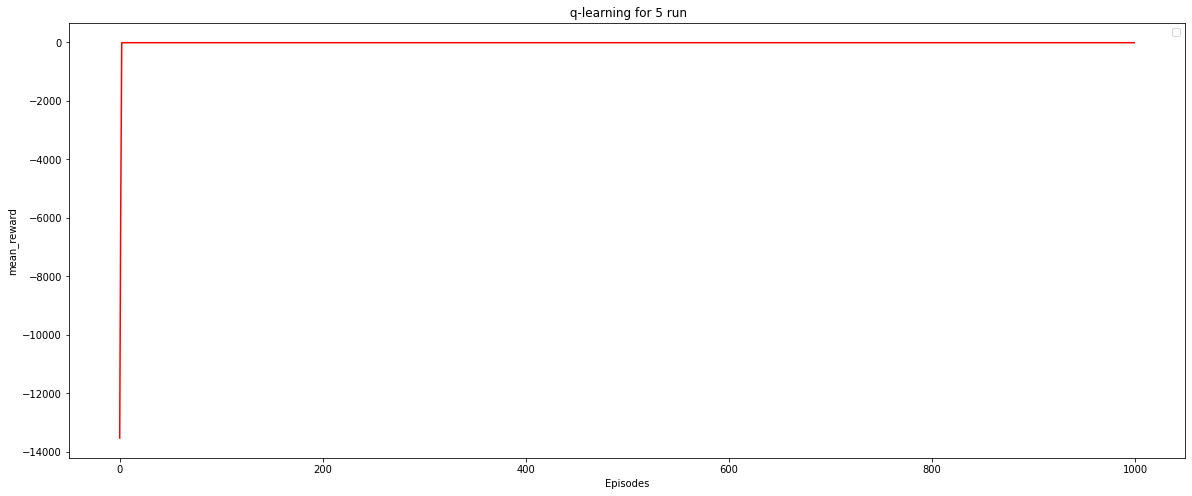

In [18]:
plott(mrq1,_," q-learning for 5 run")

In [ ]:
# render 
agent_q = Agent_Q(num_episode, 0.1, 0.9,0.1, True,num_rus)
agent_q.q_learning

In [ ]:
def save_checkpoint(state, filename):
    model_save_name = filename
    path = F"/content/drive/My Drive/{model_save_name}" 
    print("=> Saving checkpoint")
    torch.save(state, path)


def load_checkpoint(checkpoint,save_variable):
    print("=> Loading checkpoint")
    #model.load_state_dict(checkpoint["state_dict"])
    #optimizer.load_state_dict(checkpoint["optimizer"])
    rewards_per_run = checkpoint[save_variable]
    return rewards_per_run


# **policy gradient**

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import gym
from collections import deque

# define policy network
class policy_net(nn.Module):
    def __init__(self, nS, nH1,nH2, nA): # nS: state space size, nH: n. of neurons in hidden layer, nA: size action space
        super(policy_net, self).__init__()
        self.h1 = nn.Linear(nS, nH1)
        self.h2 = nn.Linear(nH1, nH2)
        self.out = nn.Linear(nH2, nA)

    # define forward pass with one hidden layer with ReLU activation and sofmax after output layer
    def forward(self, x):
        #print("x", x.shape)
        x = F.relu(self.h1(x))
        #print(x.shape)
        x = F.relu(self.h2(x))
        x = F.softmax(self.out(x), dim=1)
        #print(x.shape)
        return x

def n_run(n):

  n_rewards = []
  for i in range(n):
      print("run -------------->", i)
      env = Mars(ACTION_SPACE, MYMAP, 0.94)

      policy = policy_net(9, 32, 16, 8).to(device)
      # create an optimizer
      optimizer = torch.optim.Adam(policy.parameters())
      # initialize gamma and stats
      gamma=0.99
      n_episode = 1
      returns = []
      ave_returns = []
      render_rate = 100 # render every render_rate episodes
      episode_num = 0
      #while True:
      for e in tqdm(range(1000)):
          max_step = 0
          rewards = []
          actions = []
          states  = []
          # reset environment
          state = env.reset()
          while True:
              # render episode every render_rate epsiodes
              #if n_episode%render_rate==0:
                  #env.render()
              input = env.observation(state)
              # calculate probabilities of taking each action
              probs = policy(torch.tensor(input).unsqueeze(0).float().to(device))
              # sample an action from that set of probs
              sampler = Categorical(probs)
              action = sampler.sample()
              # use that action in the environment
              new_state, reward, done = env.step(state,action.item()) #next_state, reward, end_state
              # store state, action and reward
              states.append(input)
              actions.append(action)
              rewards.append(reward)
              state = new_state
              #print(state)
              max_step +=1
              if done or max_step>=500:
                  break
          episode_num += 1
          #if episode_num > 500:
            #break
          # preprocess rewards
          rewards = np.array(rewards)
          # calculate rewards to go for less variance
          R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))]).to(device)
          # or uncomment following line for normal rewards
          #R = torch.sum(torch.tensor(rewards))

          # preprocess states and actions
          states = torch.tensor(states).float()
          actions = torch.tensor(actions)
          # calculate gradient

          probs = policy(states.to(device)).to(device)
          sampler = Categorical(probs)
          log_probs = -sampler.log_prob(actions.to(device))   # "-" because it was built to work with gradient descent, but we are using gradient ascent
          pseudo_loss = torch.sum(log_probs * R) # loss that when differentiated with autograd gives the gradient of J(θ)
          # update policy weights
          optimizer.zero_grad()
          pseudo_loss.backward()
          optimizer.step()
          
          
          
          # calculate average return and print it out
          returns.append(np.sum(rewards))
          ave_returns.append(np.mean(returns))
          #if n_episode %200 == 0:
          #  print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
          n_episode += 1

      # close environment
      env.close()
      n_rewards.append(ave_returns)
      '''checkpoint = {'state_dict' : policy.state_dict(),
                  'n_rewards' : n_rewards 
                  }
      save_checkpoint(checkpoint, filename= checkpoint_name)'''
  return n_rewards, policy


In [23]:
checkpoint_name = "my_checkpoint_policy_gradient.pth.tar"
num_runs = 5
n_rewards, model = n_run(num_runs)

run --------------> 0


  0%|          | 0/1000 [00:00<?, ?it/s]

run --------------> 1


  0%|          | 0/1000 [00:00<?, ?it/s]

run --------------> 2


  0%|          | 0/1000 [00:00<?, ?it/s]

run --------------> 3


  0%|          | 0/1000 [00:00<?, ?it/s]

run --------------> 4


  0%|          | 0/1000 [00:00<?, ?it/s]

render_agent_position : (23, 17)


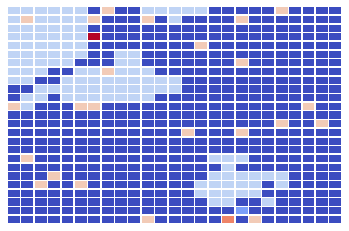

step : 0
render_agent_position : (24, 17)


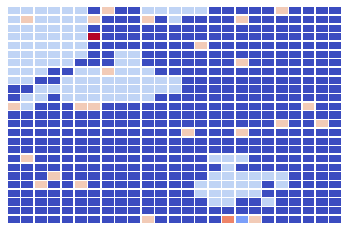

step : 1
render_agent_position : (24, 17)


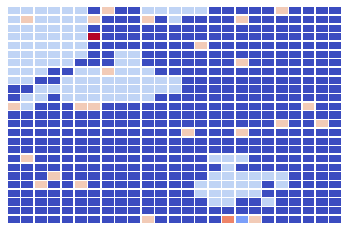

step : 2
render_agent_position : (24, 17)


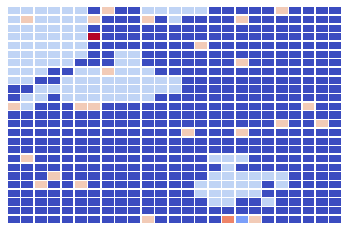

step : 3
render_agent_position : (24, 17)


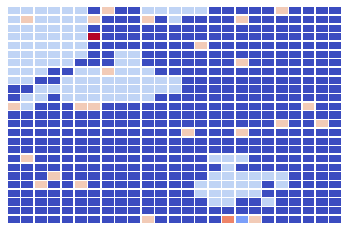

step : 4
render_agent_position : (24, 17)


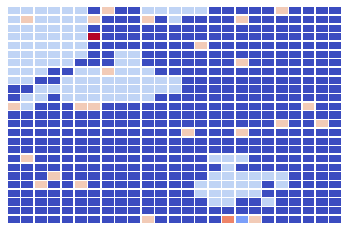

step : 5
render_agent_position : (24, 18)


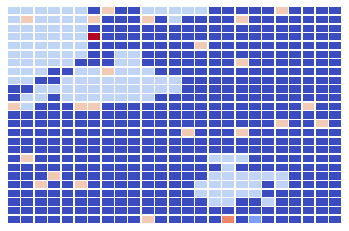

step : 6
render_agent_position : (24, 18)


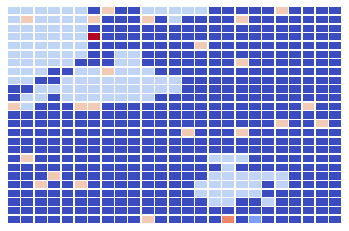

step : 7
render_agent_position : (24, 19)


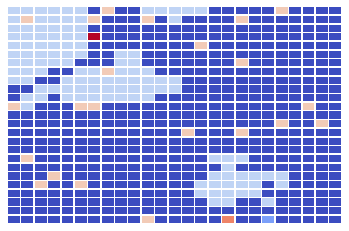

step : 8
render_agent_position : (24, 20)


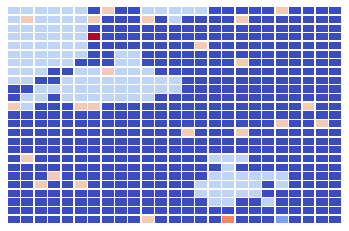

step : 9
render_agent_position : (24, 20)


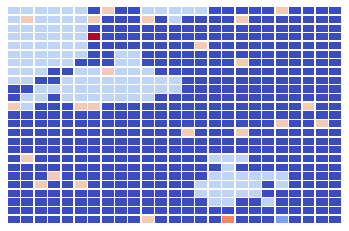

step : 10
render_agent_position : (24, 20)


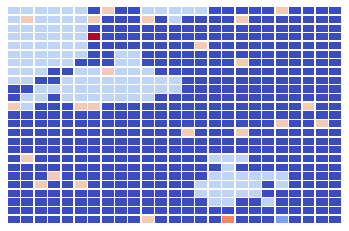

step : 11
render_agent_position : (24, 21)


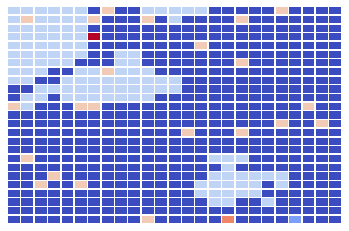

step : 12
render_agent_position : (23, 21)


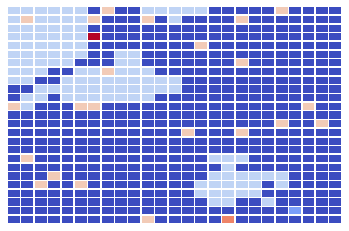

step : 13
render_agent_position : (23, 22)


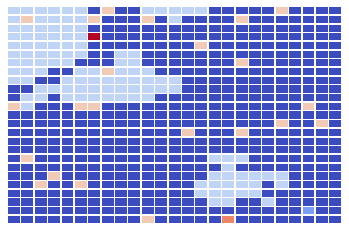

step : 14
render_agent_position : (23, 23)


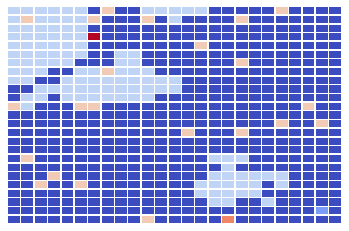

step : 15
render_agent_position : (22, 23)


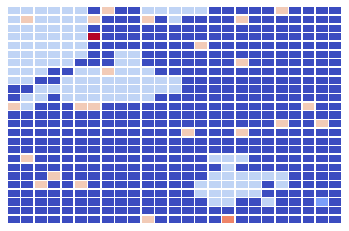

step : 16
render_agent_position : (23, 24)


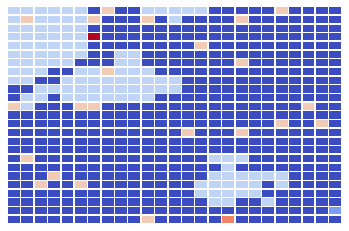

step : 17
render_agent_position : (23, 24)


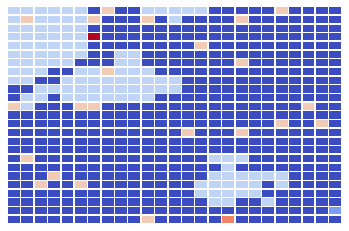

step : 18
render_agent_position : (23, 24)


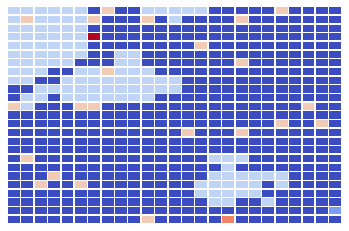

step : 19
render_agent_position : (23, 24)


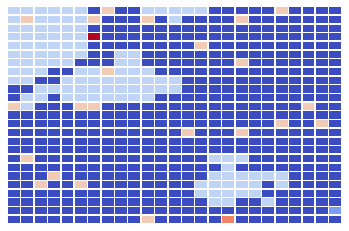

step : 20
render_agent_position : (23, 24)


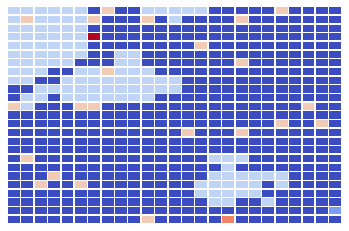

step : 21
render_agent_position : (23, 24)


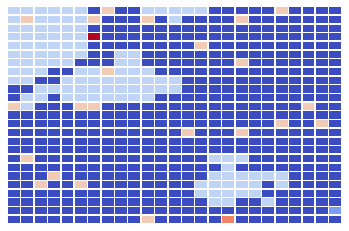

step : 22
render_agent_position : (23, 24)


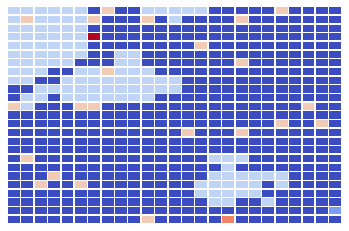

step : 23
render_agent_position : (23, 24)


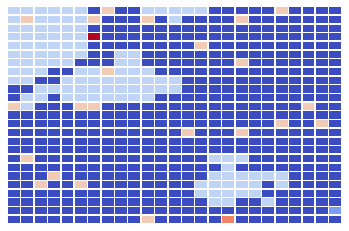

step : 24
render_agent_position : (23, 24)


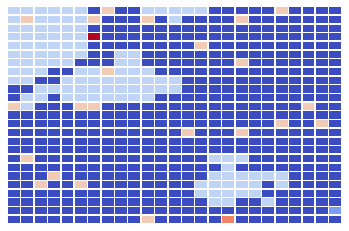

step : 25
render_agent_position : (23, 24)


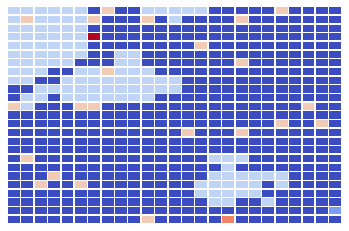

step : 26
render_agent_position : (23, 24)


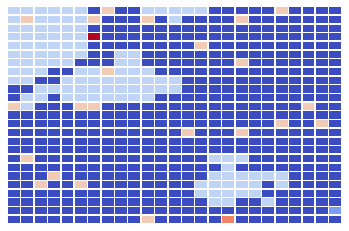

step : 27
render_agent_position : (23, 24)


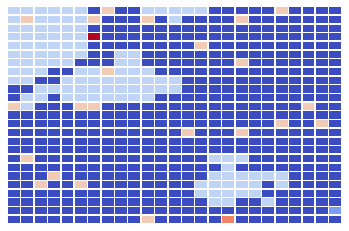

step : 28
render_agent_position : (23, 24)


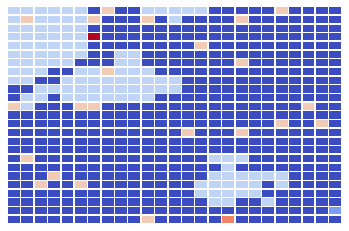

step : 29
render_agent_position : (23, 24)


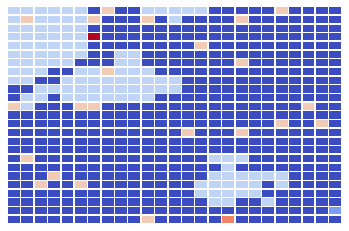

step : 30
render_agent_position : (23, 24)


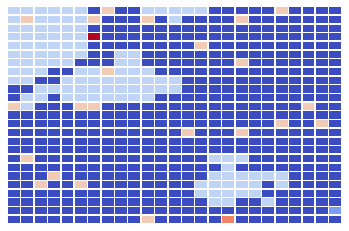

step : 31
render_agent_position : (23, 24)


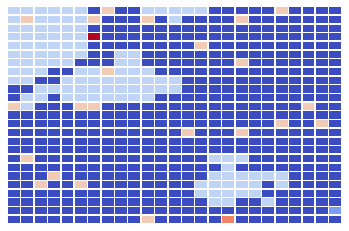

step : 32
render_agent_position : (23, 24)


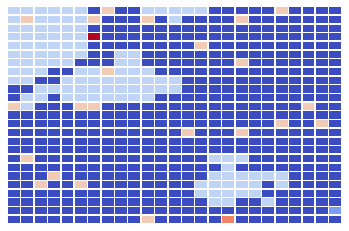

step : 33
render_agent_position : (23, 24)


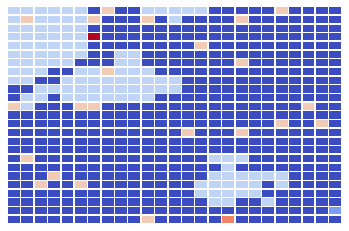

step : 34
render_agent_position : (23, 24)


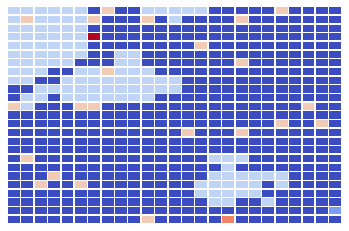

step : 35
render_agent_position : (23, 24)


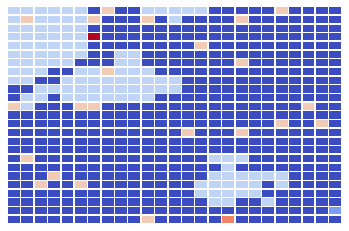

step : 36
render_agent_position : (23, 24)


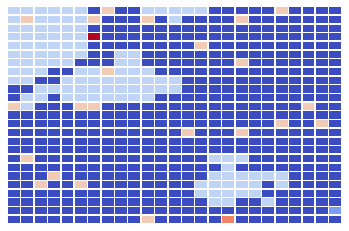

step : 37
render_agent_position : (23, 24)


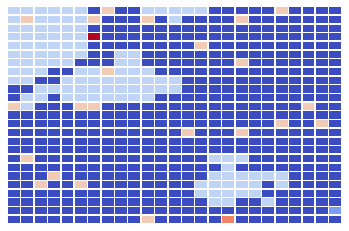

step : 38
render_agent_position : (23, 24)


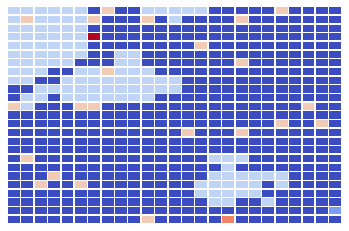

step : 39
render_agent_position : (23, 24)


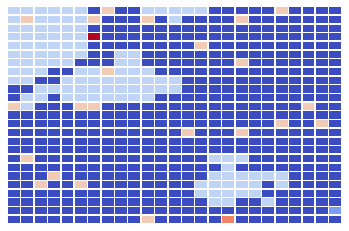

step : 40
render_agent_position : (23, 24)


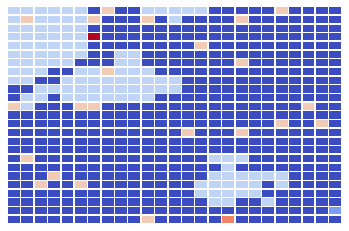

step : 41
render_agent_position : (23, 24)


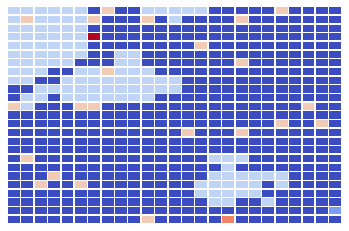

step : 42
render_agent_position : (23, 24)


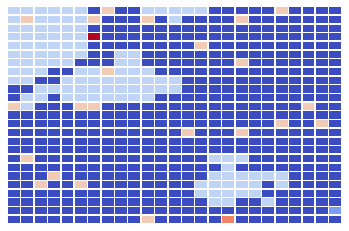

step : 43
render_agent_position : (23, 24)


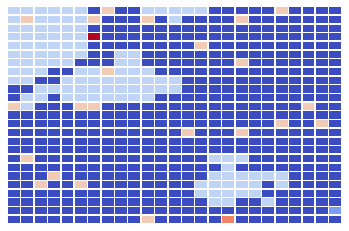

step : 44
render_agent_position : (23, 24)


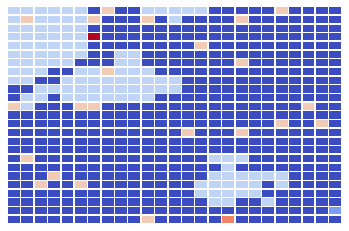

step : 45
render_agent_position : (23, 24)


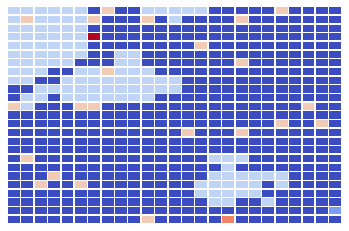

step : 46
render_agent_position : (23, 24)


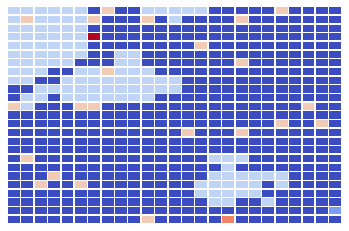

step : 47
render_agent_position : (23, 24)


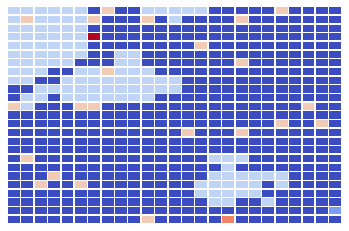

step : 48
render_agent_position : (23, 24)


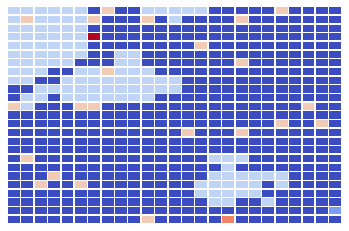

step : 49
render_agent_position : (23, 24)


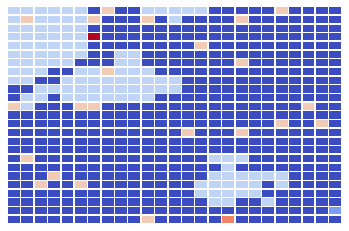

step : 50
render_agent_position : (23, 24)


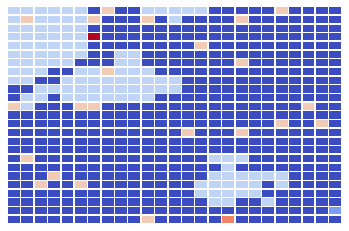

step : 51
render_agent_position : (23, 24)


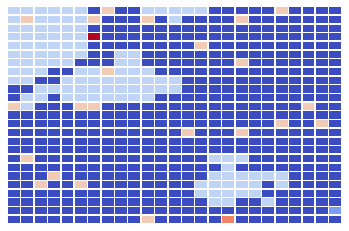

step : 52
render_agent_position : (23, 24)


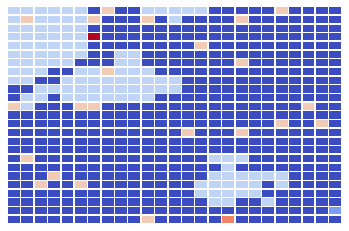

step : 53
render_agent_position : (23, 24)


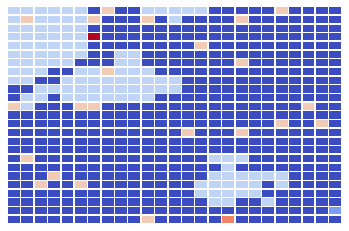

step : 54
render_agent_position : (23, 24)


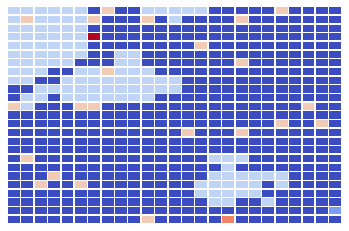

step : 55
render_agent_position : (23, 24)


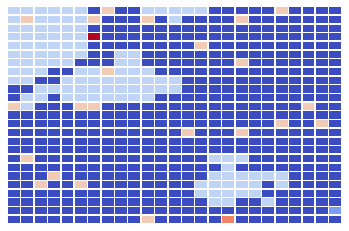

step : 56
render_agent_position : (23, 24)


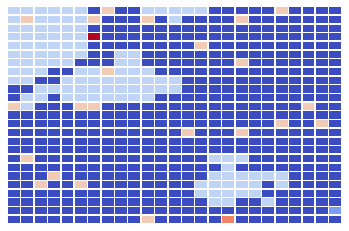

step : 57
render_agent_position : (23, 24)


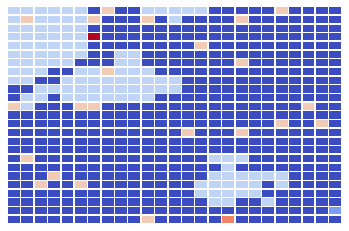

step : 58
render_agent_position : (23, 24)


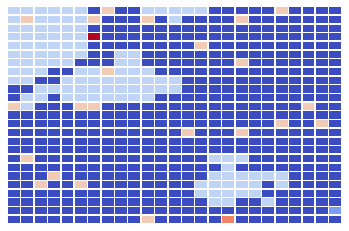

step : 59
render_agent_position : (23, 24)


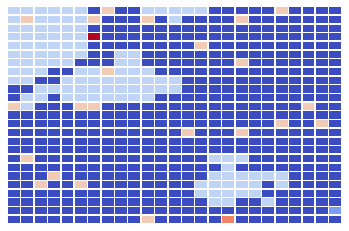

step : 60
render_agent_position : (23, 24)


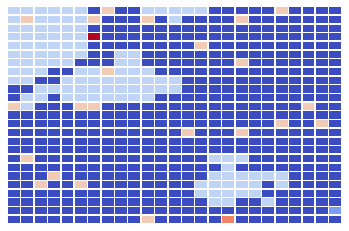

step : 61
render_agent_position : (23, 24)


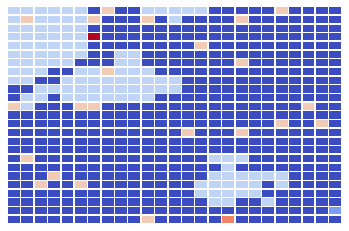

step : 62
render_agent_position : (23, 24)


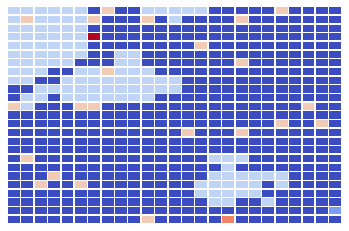

step : 63
render_agent_position : (23, 24)


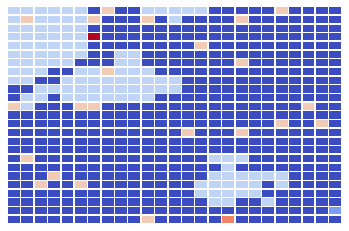

step : 64
render_agent_position : (23, 24)


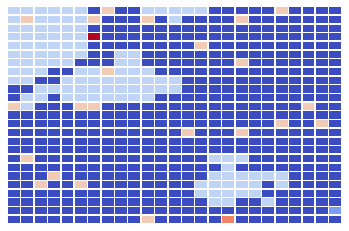

step : 65
render_agent_position : (23, 24)


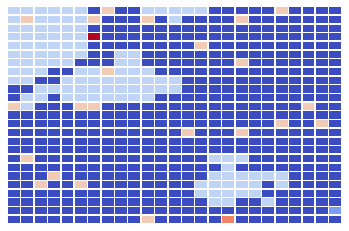

step : 66
render_agent_position : (23, 24)


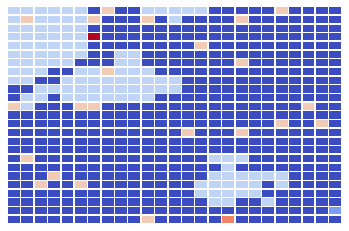

step : 67
render_agent_position : (23, 24)


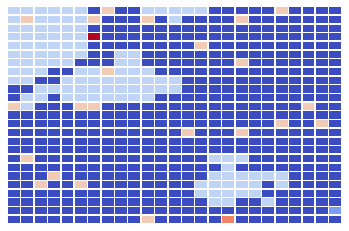

step : 68
render_agent_position : (23, 24)


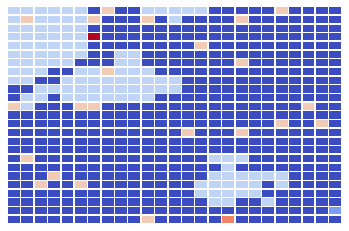

step : 69
render_agent_position : (23, 24)


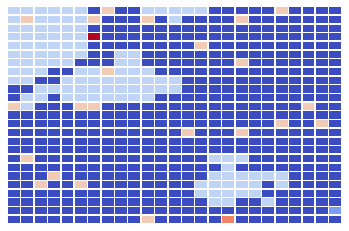

step : 70
render_agent_position : (23, 24)


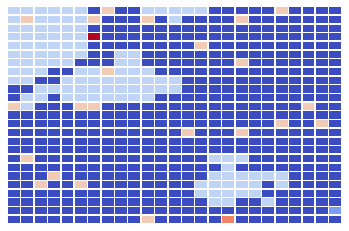

step : 71
render_agent_position : (23, 24)


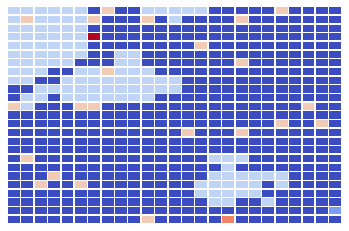

step : 72
render_agent_position : (23, 24)


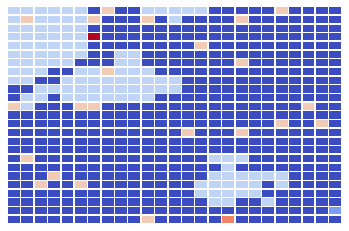

step : 73
render_agent_position : (23, 24)


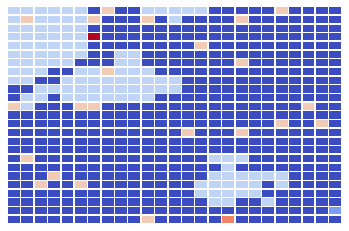

step : 74
render_agent_position : (23, 24)


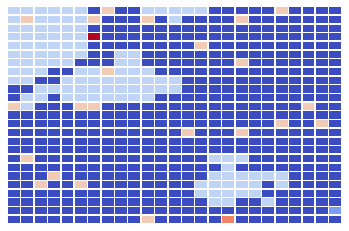

step : 75
render_agent_position : (23, 24)


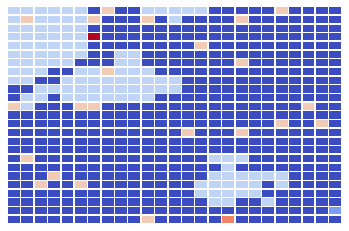

step : 76
render_agent_position : (23, 24)


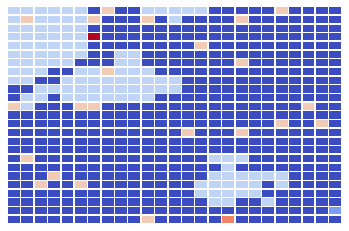

step : 77
render_agent_position : (23, 24)


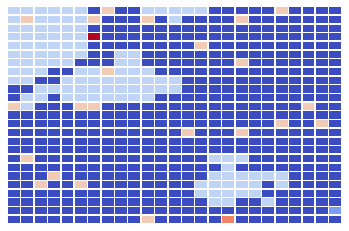

step : 78
render_agent_position : (23, 24)


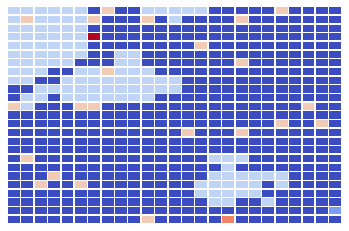

step : 79
render_agent_position : (23, 24)


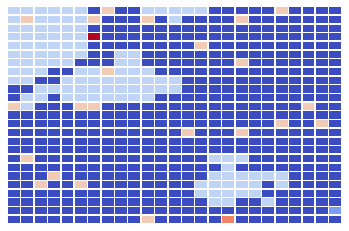

step : 80
render_agent_position : (23, 24)


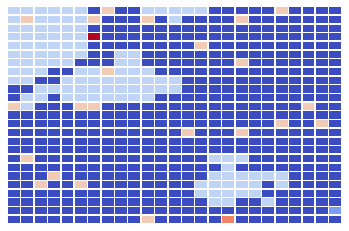

step : 81
render_agent_position : (23, 24)


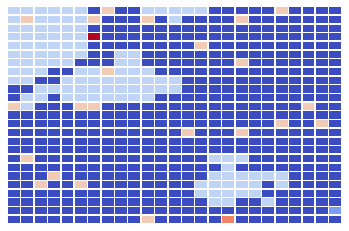

step : 82
render_agent_position : (23, 24)


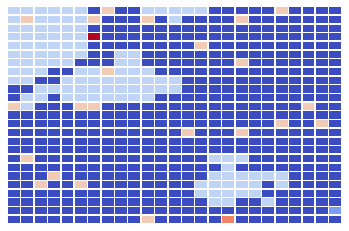

step : 83
render_agent_position : (23, 24)


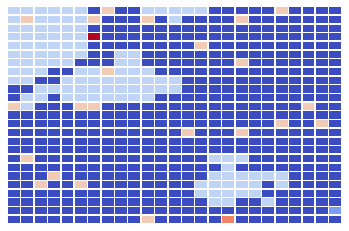

step : 84
render_agent_position : (23, 24)


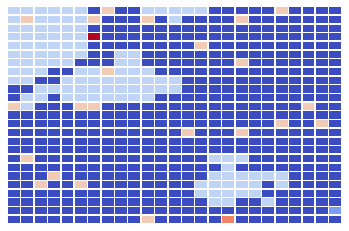

step : 85
render_agent_position : (23, 24)


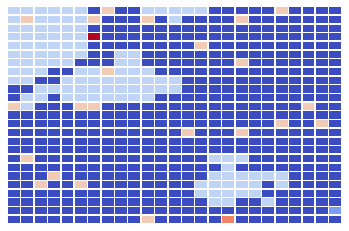

step : 86
render_agent_position : (23, 24)


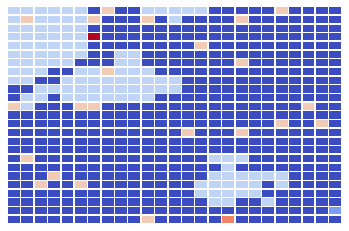

step : 87
render_agent_position : (23, 24)


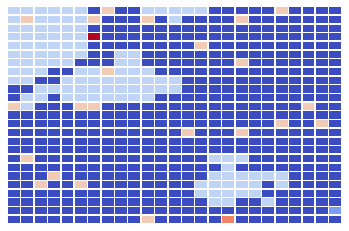

step : 88
render_agent_position : (23, 24)


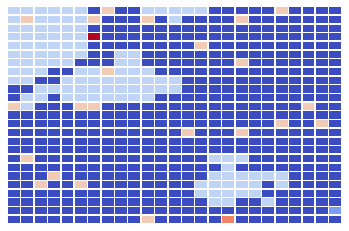

step : 89
render_agent_position : (23, 24)


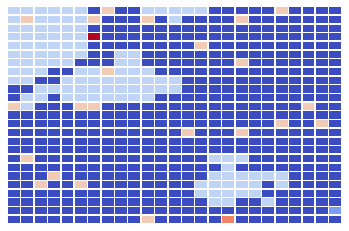

step : 90
render_agent_position : (23, 24)


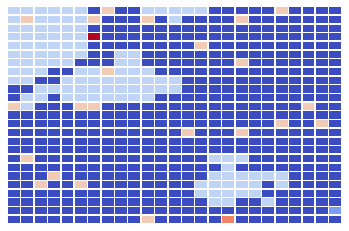

step : 91
render_agent_position : (23, 24)


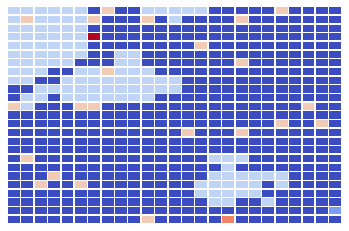

step : 92
render_agent_position : (23, 24)


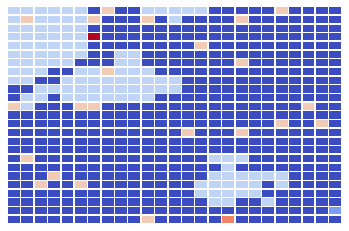

step : 93
render_agent_position : (23, 24)


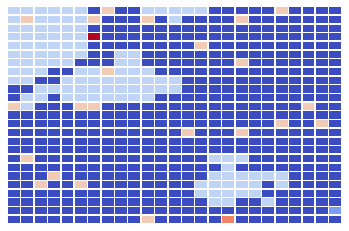

step : 94
render_agent_position : (23, 24)


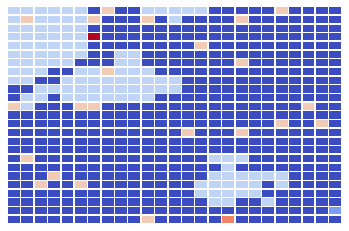

step : 95
render_agent_position : (23, 24)


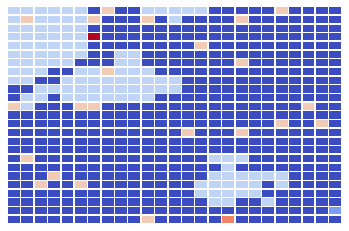

step : 96
render_agent_position : (23, 24)


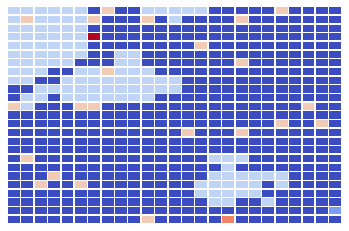

step : 97
render_agent_position : (23, 24)


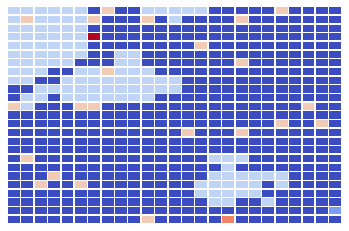

step : 98
render_agent_position : (23, 24)


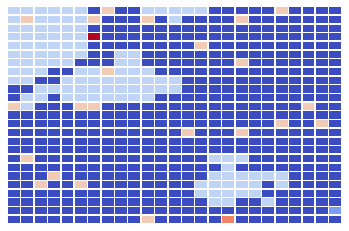

step : 99
render_agent_position : (23, 24)


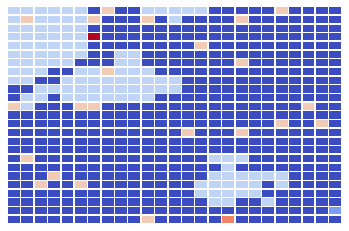

step : 100
render_agent_position : (23, 24)


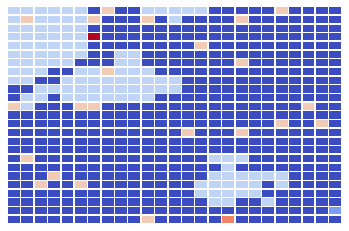

step : 101
render_agent_position : (23, 24)


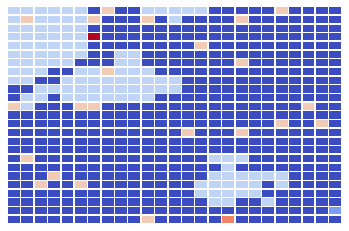

step : 102
render_agent_position : (23, 24)


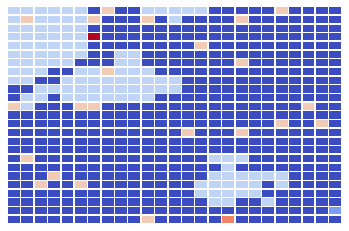

step : 103
render_agent_position : (23, 24)


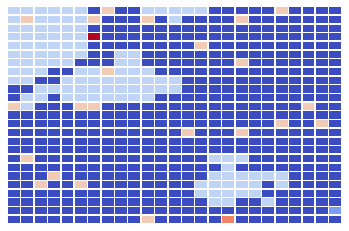

step : 104
render_agent_position : (23, 24)


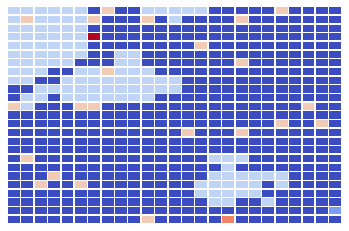

step : 105
render_agent_position : (23, 24)


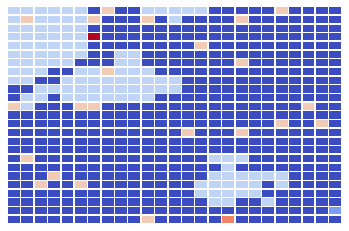

step : 106
render_agent_position : (23, 24)


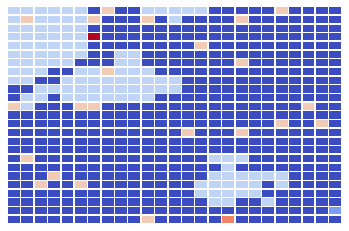

step : 107
render_agent_position : (23, 24)


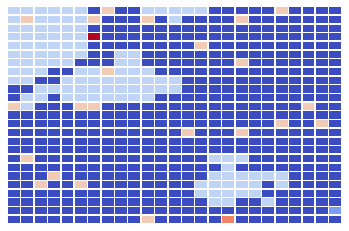

step : 108
render_agent_position : (23, 24)


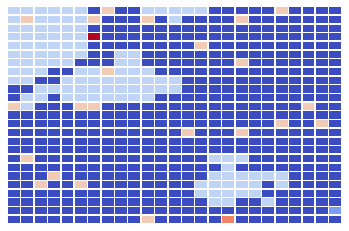

step : 109
render_agent_position : (23, 24)


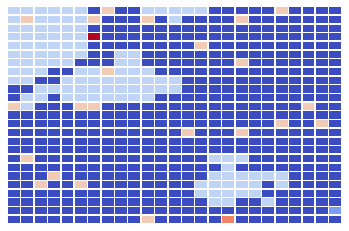

step : 110
render_agent_position : (23, 24)


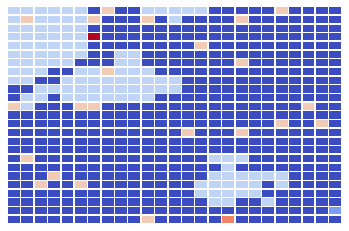

step : 111
render_agent_position : (23, 24)


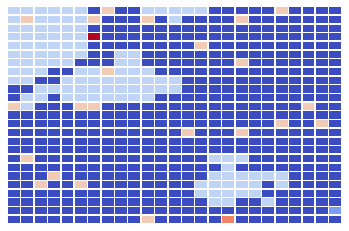

step : 112
render_agent_position : (23, 24)


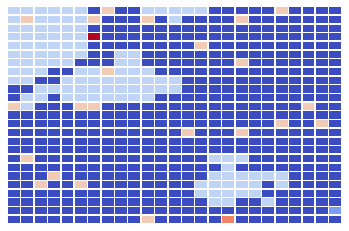

step : 113
render_agent_position : (23, 24)


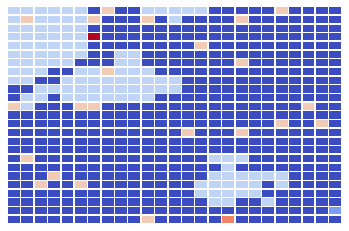

step : 114
render_agent_position : (23, 24)


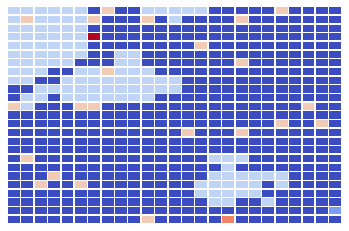

step : 115
render_agent_position : (23, 24)


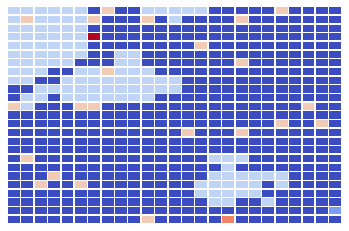

step : 116
render_agent_position : (23, 24)


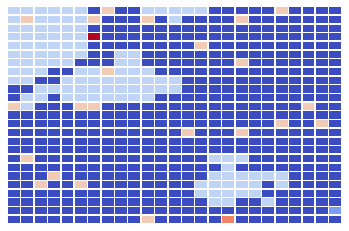

step : 117
render_agent_position : (23, 24)


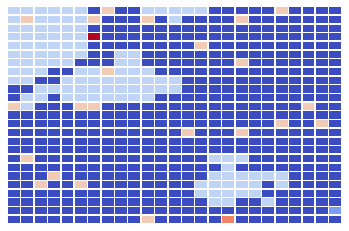

step : 118
render_agent_position : (23, 24)


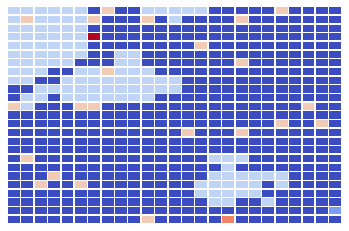

step : 119
render_agent_position : (23, 24)


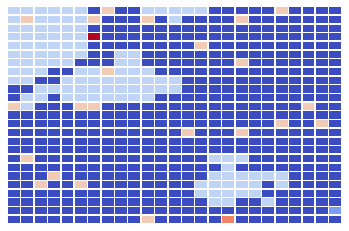

step : 120
render_agent_position : (23, 24)


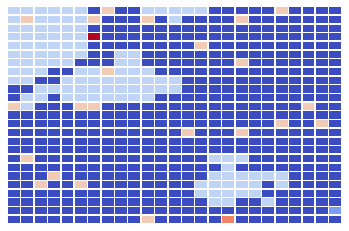

step : 121
render_agent_position : (23, 24)


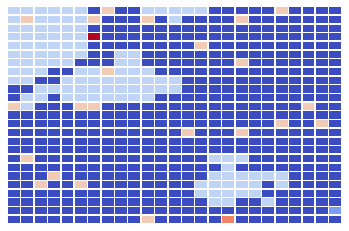

step : 122
render_agent_position : (23, 24)


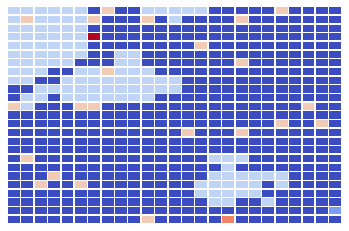

step : 123
render_agent_position : (23, 24)


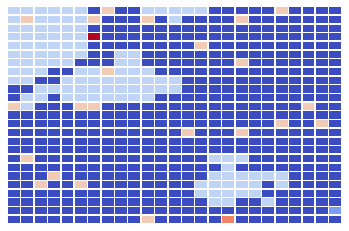

step : 124
render_agent_position : (23, 24)


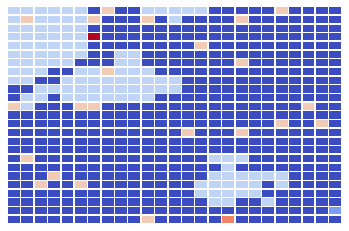

step : 125
render_agent_position : (23, 24)


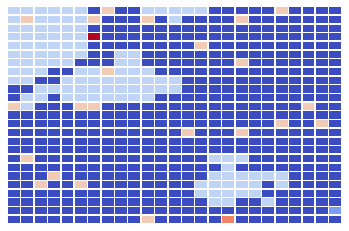

step : 126
render_agent_position : (23, 24)


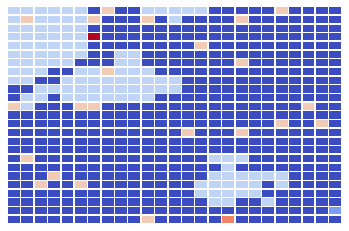

step : 127
render_agent_position : (23, 24)


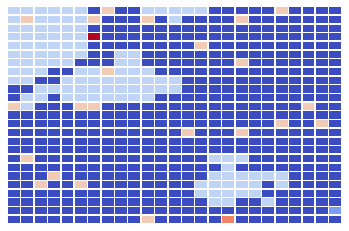

step : 128
render_agent_position : (23, 24)


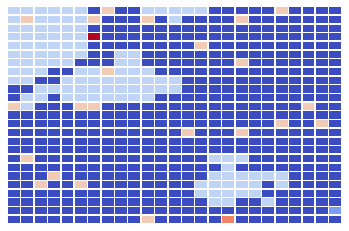

step : 129
render_agent_position : (23, 24)


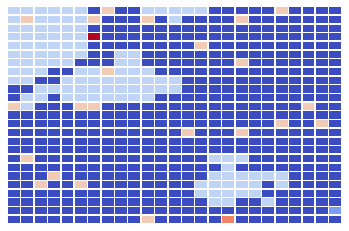

step : 130
render_agent_position : (23, 24)


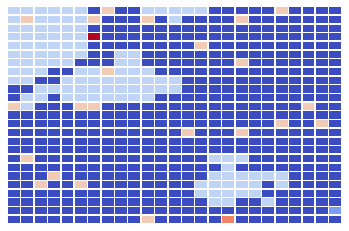

step : 131
render_agent_position : (23, 24)


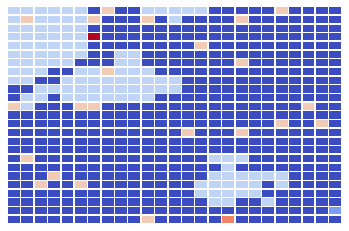

step : 132
render_agent_position : (23, 24)


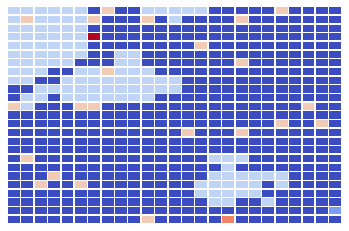

step : 133
render_agent_position : (23, 24)


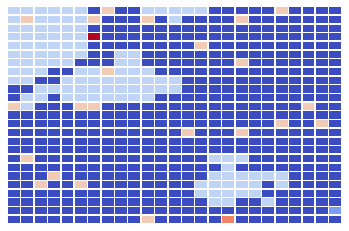

step : 134
render_agent_position : (23, 24)


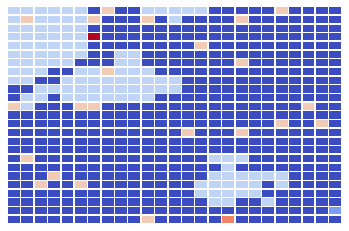

step : 135
render_agent_position : (23, 24)


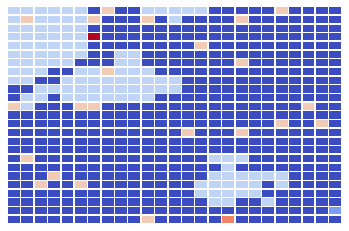

step : 136
render_agent_position : (23, 24)


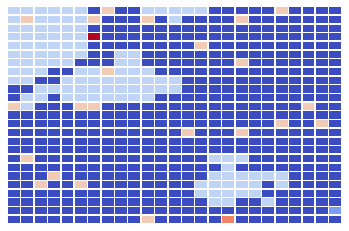

step : 137
render_agent_position : (23, 24)


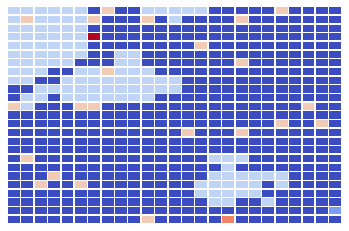

step : 138
render_agent_position : (23, 24)


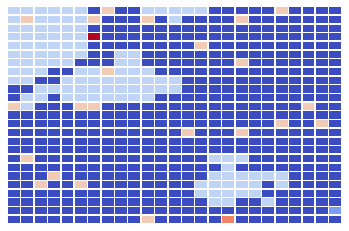

step : 139
render_agent_position : (23, 24)


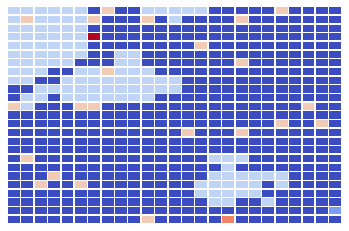

step : 140
render_agent_position : (23, 24)


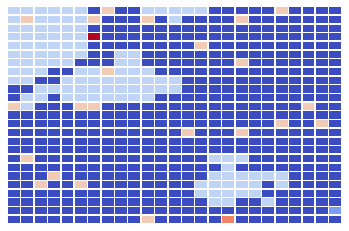

step : 141
render_agent_position : (23, 24)


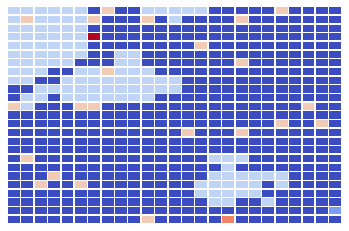

step : 142
render_agent_position : (23, 24)


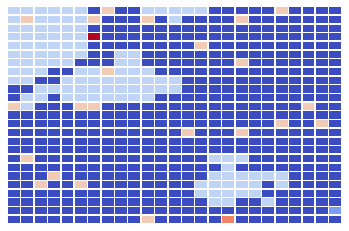

step : 143
render_agent_position : (23, 24)


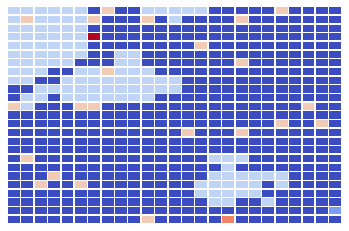

step : 144
render_agent_position : (23, 24)


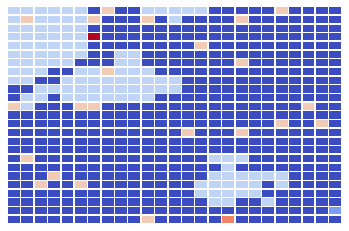

step : 145
render_agent_position : (23, 24)


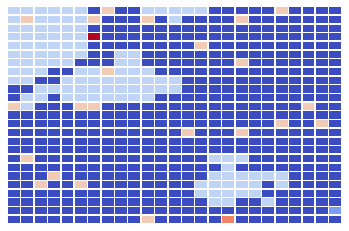

step : 146
render_agent_position : (23, 24)


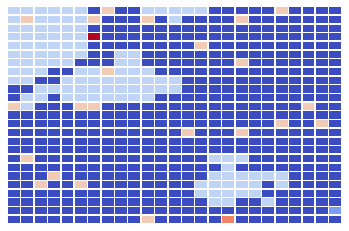

step : 147
render_agent_position : (23, 24)


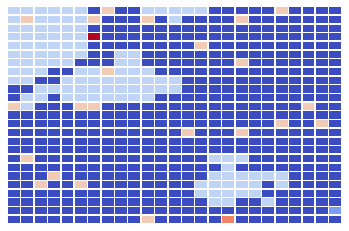

step : 148
render_agent_position : (23, 24)


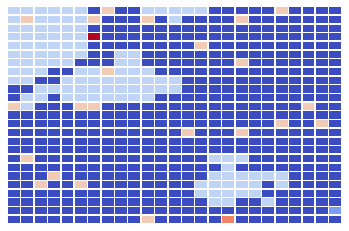

step : 149
render_agent_position : (23, 24)


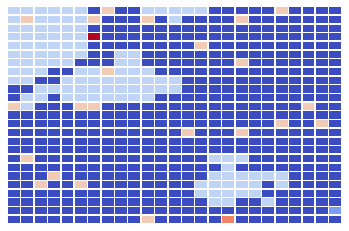

step : 150
render_agent_position : (23, 24)


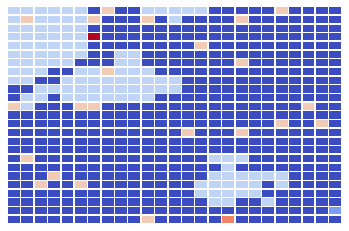

step : 151
render_agent_position : (23, 24)


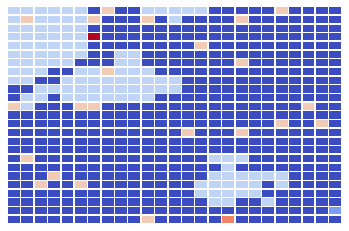

step : 152
render_agent_position : (23, 24)


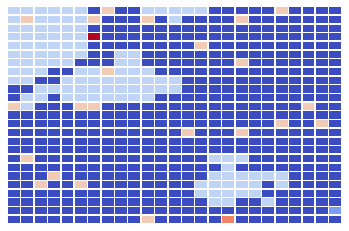

step : 153
render_agent_position : (23, 24)


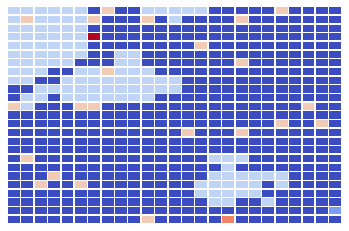

step : 154
render_agent_position : (23, 24)


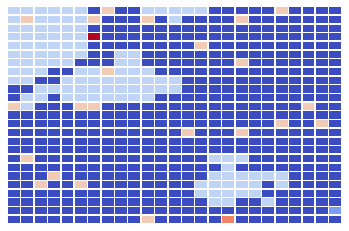

step : 155
render_agent_position : (23, 24)


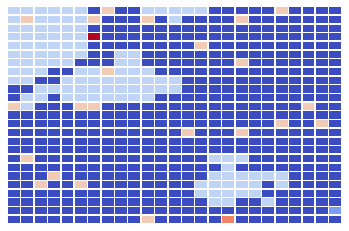

step : 156
render_agent_position : (23, 24)


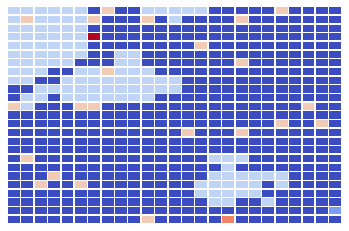

step : 157
render_agent_position : (23, 24)


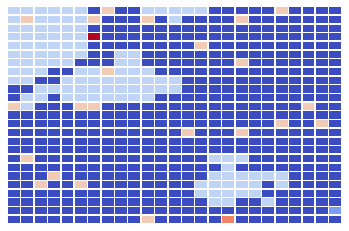

step : 158
render_agent_position : (23, 24)


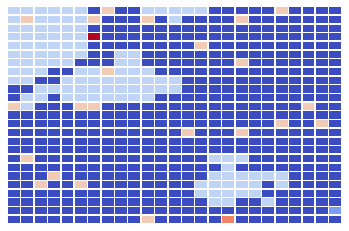

step : 159
render_agent_position : (23, 24)


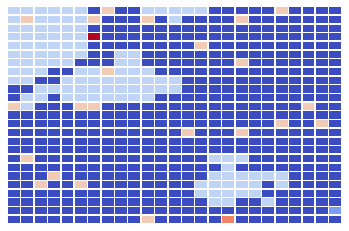

step : 160
render_agent_position : (23, 24)


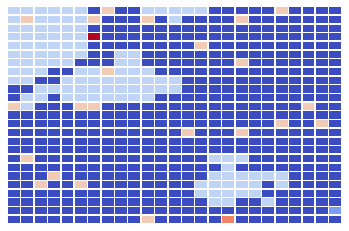

step : 161
render_agent_position : (23, 24)


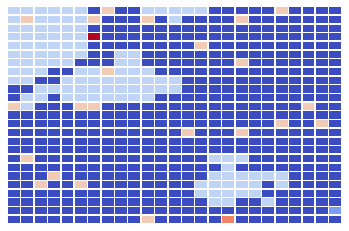

step : 162
render_agent_position : (23, 24)


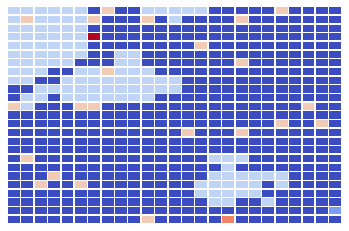

step : 163
render_agent_position : (23, 24)


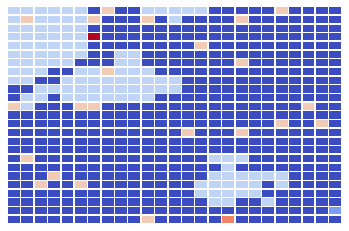

step : 164
render_agent_position : (23, 24)


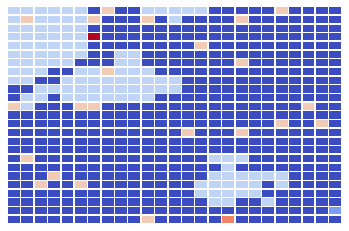

step : 165
render_agent_position : (23, 24)


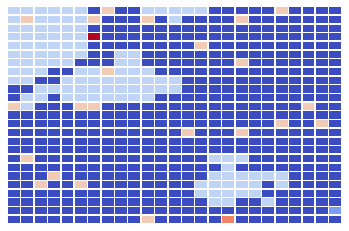

step : 166
render_agent_position : (23, 24)


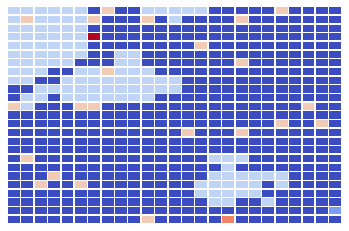

step : 167
render_agent_position : (23, 24)


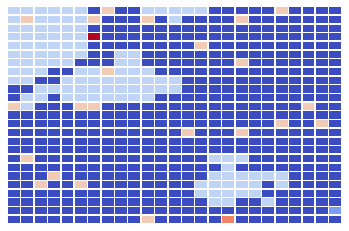

step : 168
render_agent_position : (23, 24)


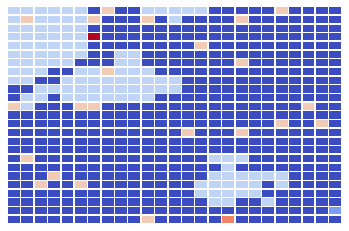

step : 169
render_agent_position : (23, 24)


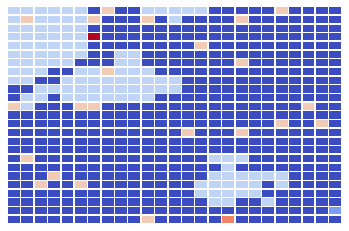

step : 170
render_agent_position : (23, 24)


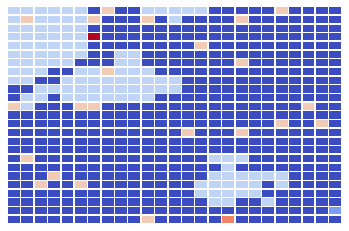

step : 171
render_agent_position : (23, 24)


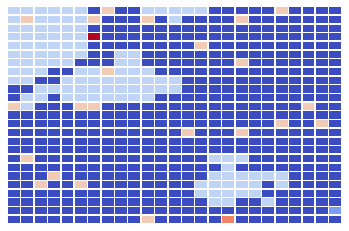

step : 172
render_agent_position : (23, 24)


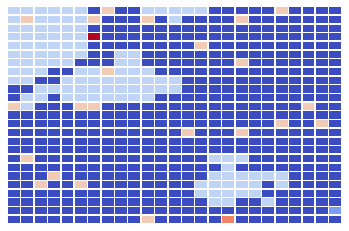

step : 173
render_agent_position : (23, 24)


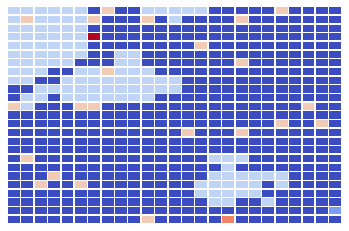

step : 174
render_agent_position : (23, 24)


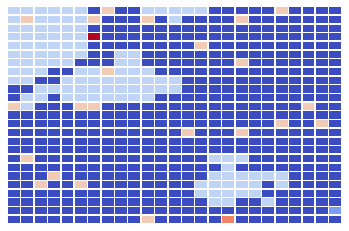

step : 175
render_agent_position : (23, 24)


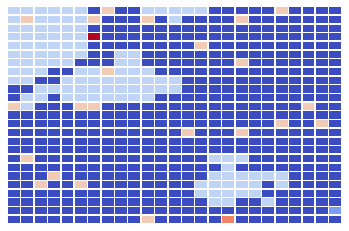

step : 176
render_agent_position : (23, 24)


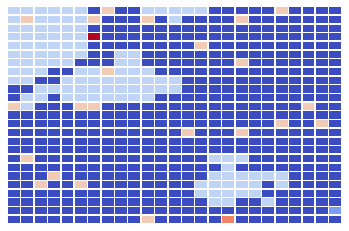

step : 177
render_agent_position : (23, 24)


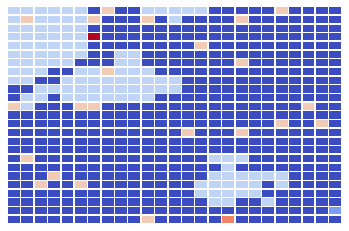

step : 178
render_agent_position : (23, 24)


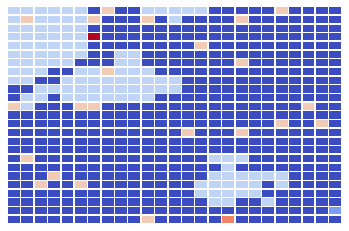

step : 179
render_agent_position : (23, 24)


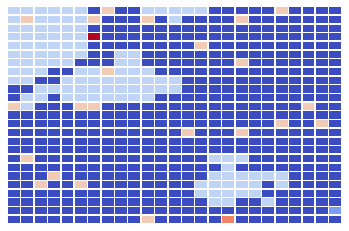

step : 180
render_agent_position : (23, 24)


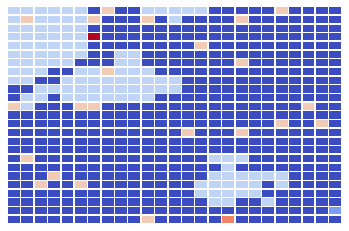

step : 181
render_agent_position : (23, 24)


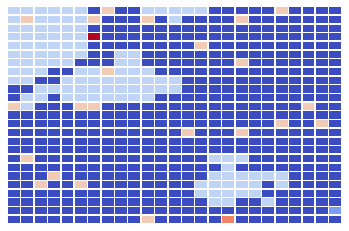

step : 182
render_agent_position : (23, 24)


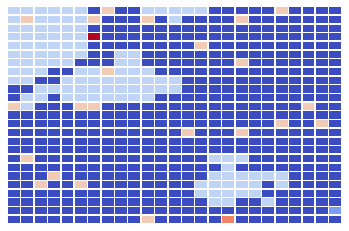

step : 183
render_agent_position : (23, 24)


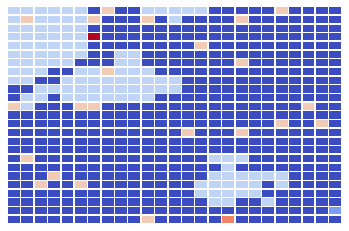

step : 184
render_agent_position : (23, 24)


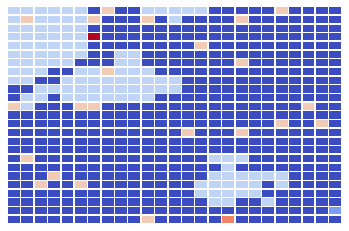

step : 185
render_agent_position : (23, 24)


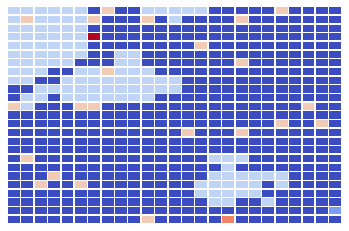

step : 186
render_agent_position : (23, 24)


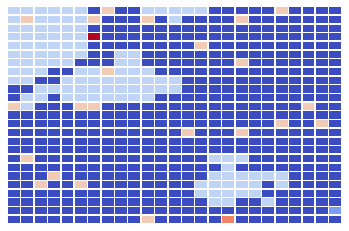

step : 187
render_agent_position : (23, 24)


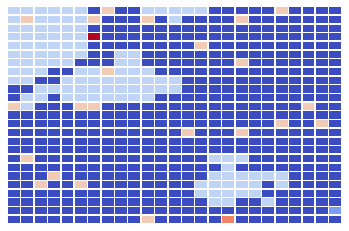

step : 188
render_agent_position : (23, 24)


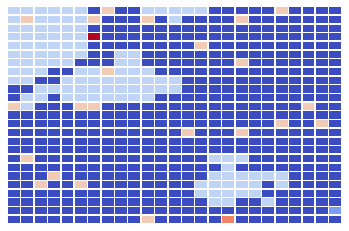

step : 189
render_agent_position : (23, 24)


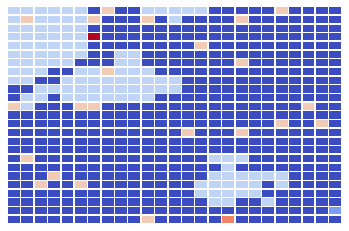

step : 190
render_agent_position : (23, 24)


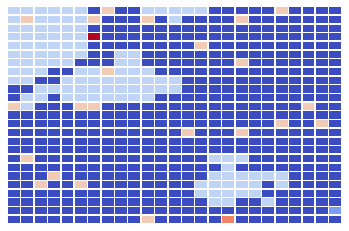

step : 191
render_agent_position : (23, 24)


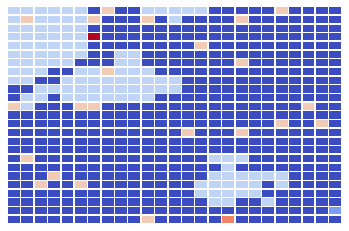

step : 192
render_agent_position : (23, 24)


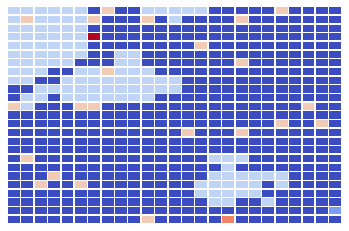

step : 193
render_agent_position : (23, 24)


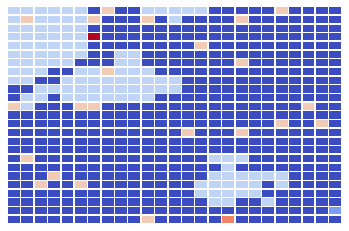

step : 194
render_agent_position : (23, 24)


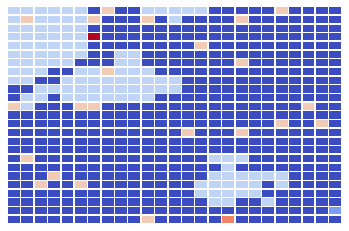

step : 195
render_agent_position : (23, 24)


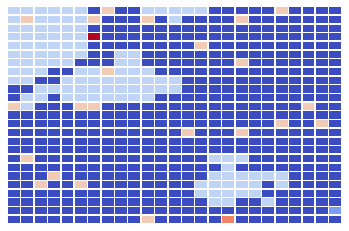

step : 196
render_agent_position : (23, 24)


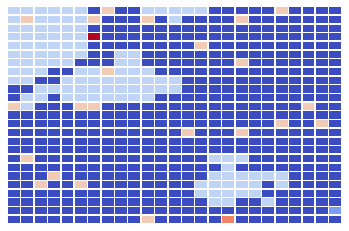

step : 197
render_agent_position : (23, 24)


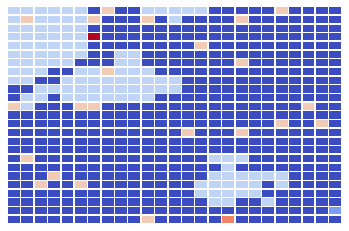

step : 198
render_agent_position : (23, 24)


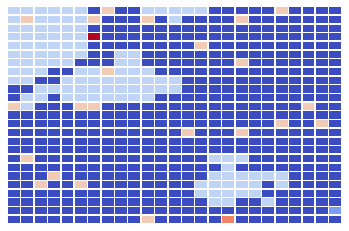

step : 199
render_agent_position : (23, 24)


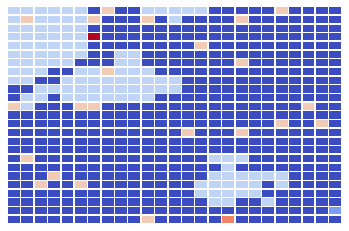

step : 200
render_agent_position : (23, 24)


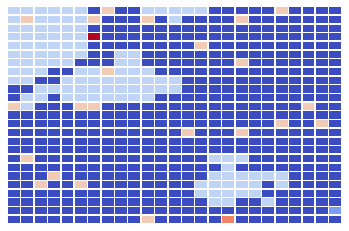

step : 201
render_agent_position : (23, 24)


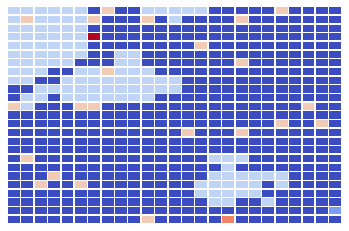

step : 202
render_agent_position : (23, 24)


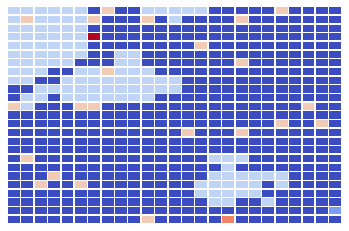

step : 203
render_agent_position : (23, 24)


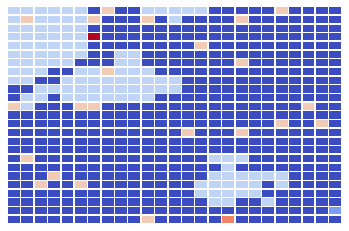

step : 204
render_agent_position : (23, 24)


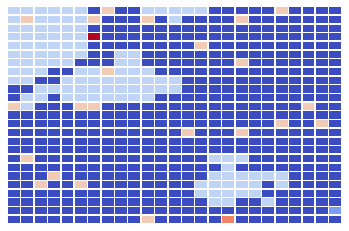

step : 205
render_agent_position : (23, 24)


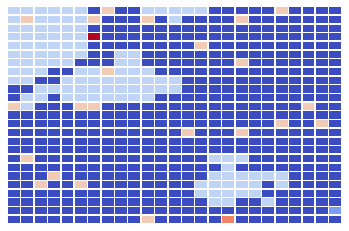

step : 206
render_agent_position : (23, 24)


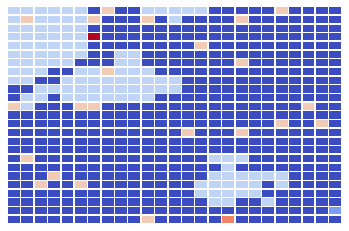

step : 207
render_agent_position : (23, 24)


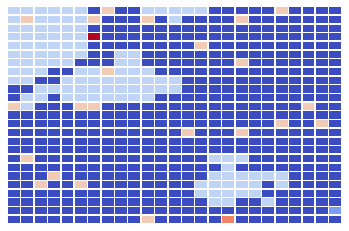

step : 208
render_agent_position : (23, 24)


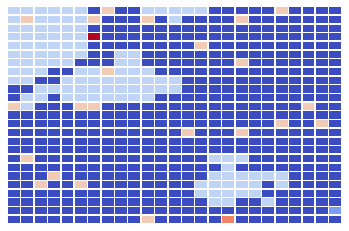

step : 209
render_agent_position : (23, 24)


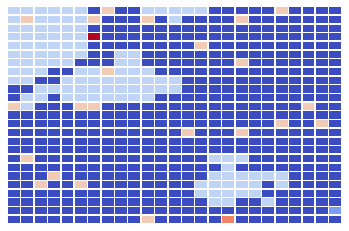

step : 210
render_agent_position : (23, 24)


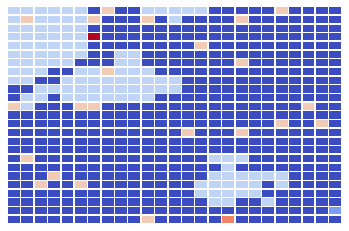

step : 211
render_agent_position : (23, 24)


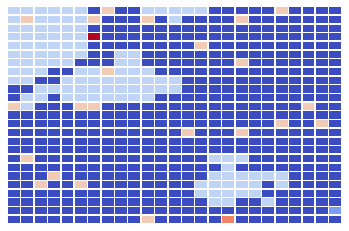

step : 212
render_agent_position : (23, 24)


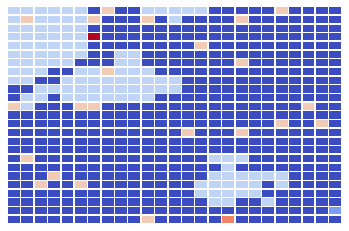

step : 213
render_agent_position : (23, 24)


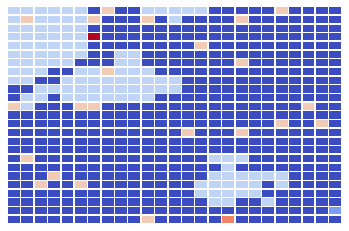

step : 214
render_agent_position : (23, 24)


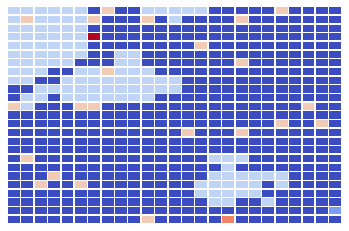

step : 215
render_agent_position : (23, 24)


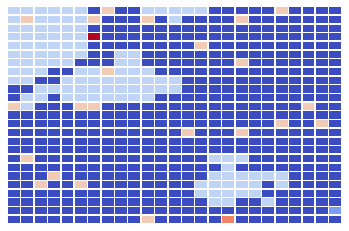

step : 216
render_agent_position : (23, 24)


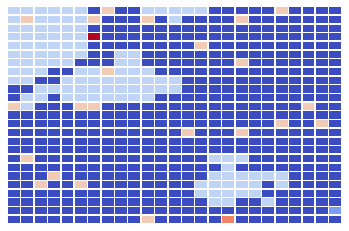

step : 217
render_agent_position : (23, 24)


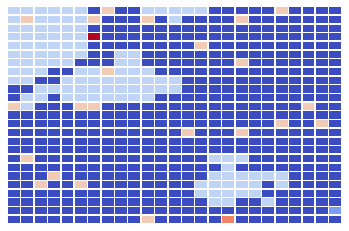

step : 218
render_agent_position : (23, 24)


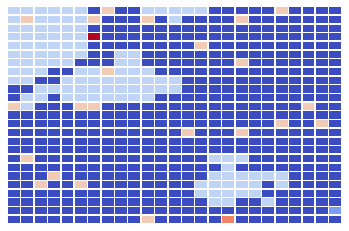

step : 219
render_agent_position : (23, 24)


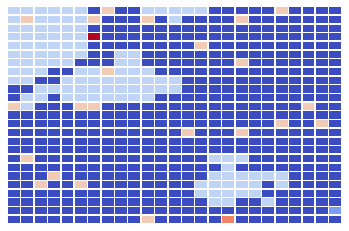

step : 220
render_agent_position : (23, 24)


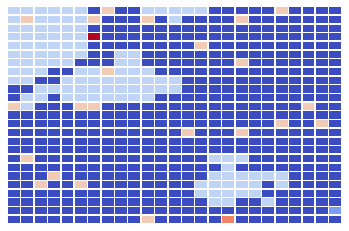

step : 221
render_agent_position : (23, 24)


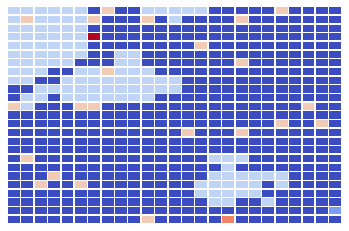

step : 222
render_agent_position : (23, 24)


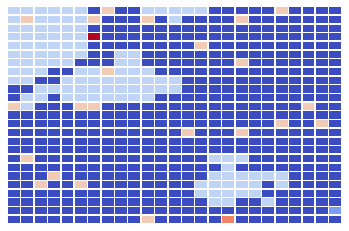

step : 223
render_agent_position : (23, 24)


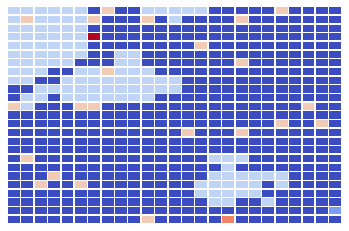

step : 224
render_agent_position : (23, 24)


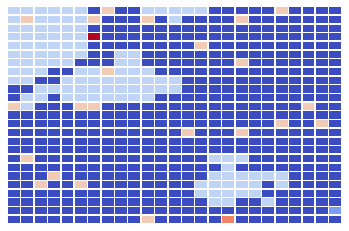

step : 225
render_agent_position : (23, 24)


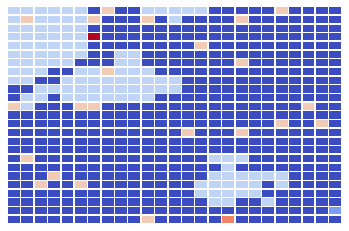

step : 226
render_agent_position : (23, 24)


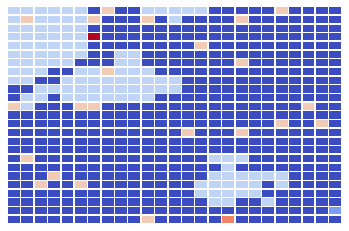

step : 227
render_agent_position : (23, 24)


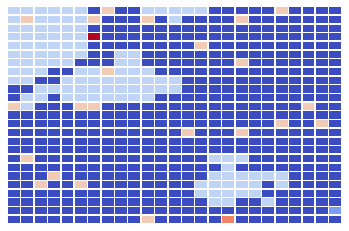

step : 228
render_agent_position : (23, 24)


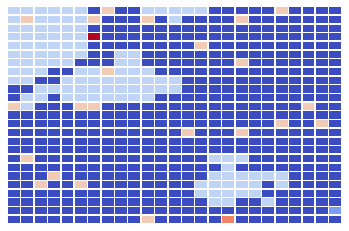

step : 229
render_agent_position : (23, 24)


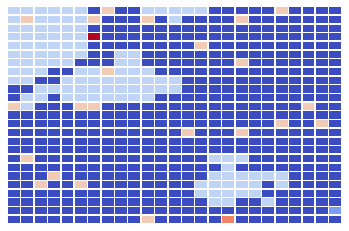

step : 230
render_agent_position : (23, 24)


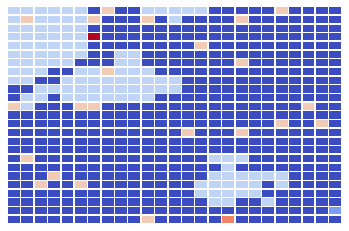

step : 231
render_agent_position : (23, 24)


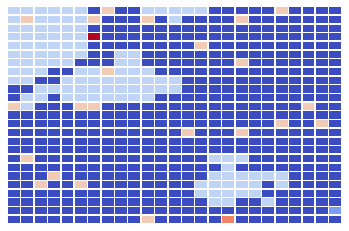

step : 232
render_agent_position : (23, 24)


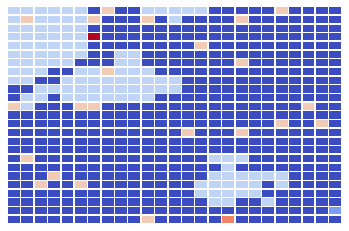

step : 233
render_agent_position : (23, 24)


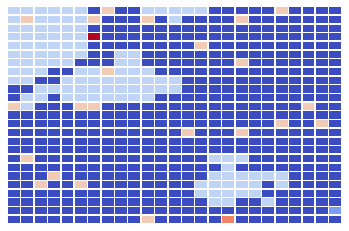

step : 234
render_agent_position : (23, 24)


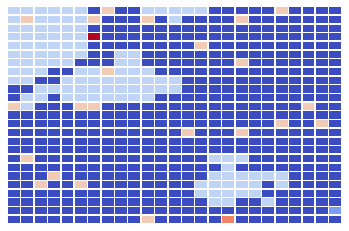

step : 235
render_agent_position : (23, 24)


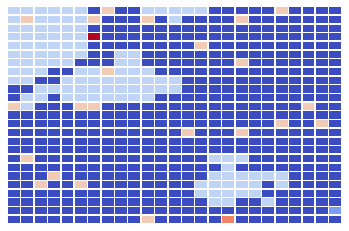

step : 236
render_agent_position : (23, 24)


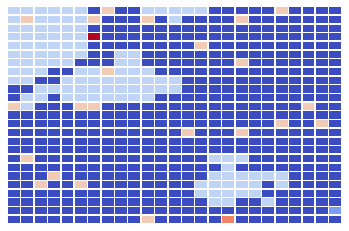

step : 237
render_agent_position : (23, 24)


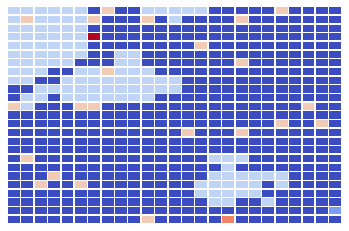

step : 238
render_agent_position : (23, 24)


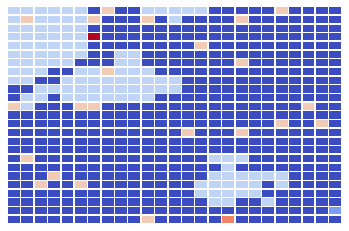

step : 239
render_agent_position : (23, 24)


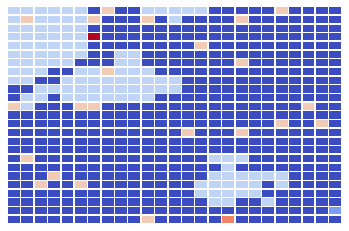

step : 240
render_agent_position : (23, 24)


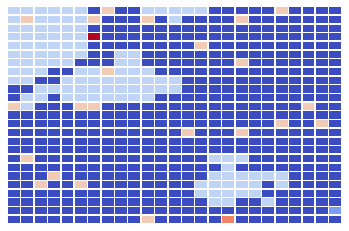

step : 241
render_agent_position : (23, 24)


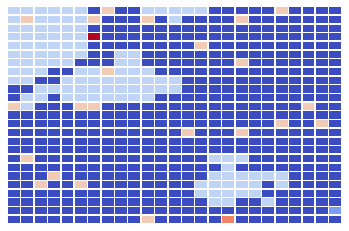

step : 242
render_agent_position : (23, 24)


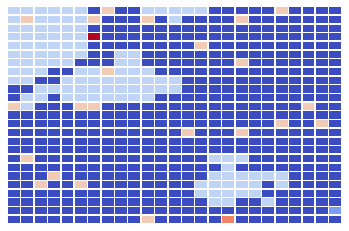

step : 243
render_agent_position : (23, 24)


KeyboardInterrupt: ignored

In [27]:
state = env.reset()
env.render()
#images.append(img)
max_step = 50
max_step = 0
while True:
    print("step :" ,max_step)
    input = env.observation(state)
    probs = model(torch.tensor(input).unsqueeze(0).float().to(device))
    # sample an action from that set of probs
    sampler = Categorical(probs)
    action = sampler.sample()
    new_state, reward, done = env.step(state,action.item()) #next_state, reward, end_state
    env.render()
    max_step +=1
    if max_step>=500:
      break
    state = new_state


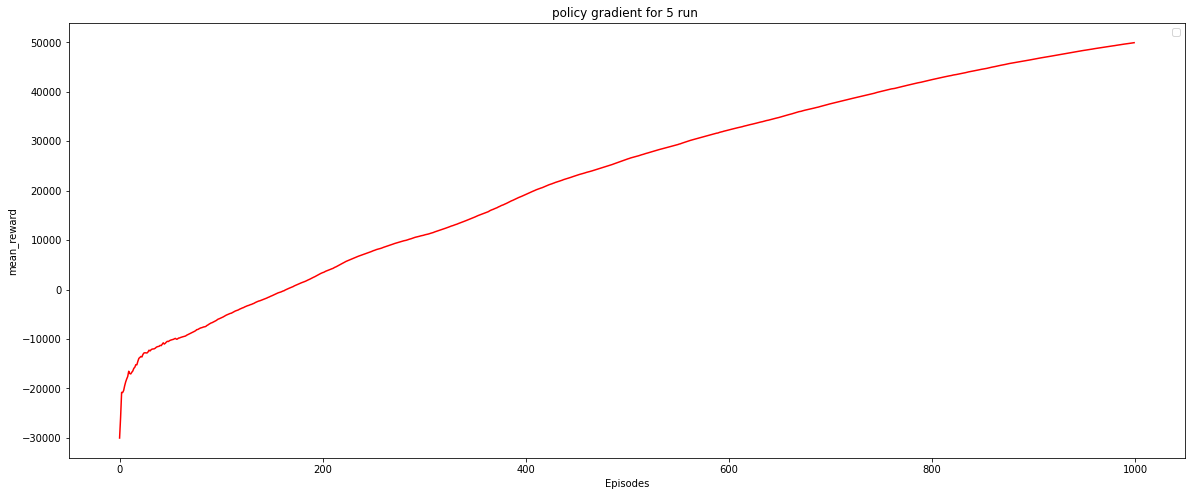

In [28]:
plott(np.mean(np.array(n_rewards),axis =0),_,"policy gradient for 5 run ")

In [ ]:
#load 
checkpoint_name = "my_checkpoint_policy_gradient.pth.tar"
path = F"/content/drive/My Drive/{checkpoint_name}" 
save_variable = 'n_rewards'
rewards_highway = load_checkpoint(torch.load(path),save_variable)

In [ ]:
state = env.reset()
max_step = 0
while True:
  input = env.observation(state)
  # calculate probabilities of taking each action
  probs = model(torch.tensor(input).unsqueeze(0).float().to(device))
  # sample an action from that set of probs
  sampler = Categorical(probs)
  action = sampler.sample()
  # use that action in the environment
  new_state, reward, done = env.step(state,action.item()) #next_state, reward, end_state
  state = new_state
  
  #print(state)
  max_step +=1
  if done or max_step>=500:
    break

 # **ppo**

In [29]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from gym import Env
from tqdm.notebook import tqdm
import torch

In [30]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []


In [31]:
class ActorNetwork(nn.Module): #baseline?
    def __init__(self, n_actions, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

    
        self.actor = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist



In [32]:
class CriticNetwork(nn.Module):#policy?
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256):#,chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

      
        self.critic = nn.Sequential(
                nn.Linear(input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value


In [33]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95, policy_clip=0.2, batch_size=64, n_epochs=10):

        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

  

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr, reward_arr, dones_arr, batches = self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*(1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               


In [34]:
checkpoint_name = "my_checkpoint_ppo.pth.tar"
env = Mars(ACTION_SPACE, MYMAP, 0.94)  # action_space, env_map, prob_transition = 0.94
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions = 8, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs, input_dims = 9)
n_games = 1000


best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in tqdm(range(n_games)):
        state = env.reset()
        observation = env.observation(state)
        #observation = env.reset
        step_num = 0
        done = False
        score = 0
        while not done:
           
            action, prob, val = agent.choose_action(observation)
            #observation_, reward, done, info = env.step(action)
            #new_state, reward, done = env.step(state,action.item()) ours
            state_, reward, done = env.step(state, action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation_ = env.observation(state_)
            state = state_
            observation = observation_
            
            step_num += 1
            if step_num>500:
                break

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            #agent.save_models()
        
        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
        


checkpoint = {'score_history' : score_history }
save_checkpoint(checkpoint, filename= checkpoint_name)


  0%|          | 0/1000 [00:00<?, ?it/s]

episode 0 score -25718.0 avg score -25718.0 time_steps 501 learning_steps 25
episode 1 score -7790.0 avg score -16754.0 time_steps 1002 learning_steps 50
episode 2 score -1102.0 avg score -11536.7 time_steps 1503 learning_steps 75
episode 3 score -64058.0 avg score -24667.0 time_steps 2004 learning_steps 100
episode 4 score -2130.0 avg score -20159.6 time_steps 2505 learning_steps 125
episode 5 score -9240.0 avg score -18339.7 time_steps 3006 learning_steps 150
episode 6 score 115950.0 avg score 844.6 time_steps 3507 learning_steps 175
episode 7 score -5010.0 avg score 112.8 time_steps 4008 learning_steps 200
episode 8 score -5010.0 avg score -456.4 time_steps 4509 learning_steps 225
episode 9 score -5010.0 avg score -911.8 time_steps 5010 learning_steps 250
episode 10 score -5010.0 avg score -1284.4 time_steps 5511 learning_steps 275
episode 11 score -5010.0 avg score -1594.8 time_steps 6012 learning_steps 300
episode 12 score -5010.0 avg score -1857.5 time_steps 6513 learning_steps 3

NameError: ignored

In [35]:
x = [i+1 for i in range(len(score_history))]

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-1000):(i+1)])
    #plt.plot(x, running_avg)
    #plt.title('Running average of previous 1000 scores')
    return running_avg
    #plt.savefig(figure_file)

In [ ]:
running_avg = plot_learning_curve(x, score_history)

In [44]:
def plott(a,b,title): 

    plt.figure(figsize=(20,8))
    plt.plot(a, color='r', label='policy_gradient')
    plt.plot(b, color='b', label='ppo')
    plt.xlabel("Episodes")
    plt.ylabel("mean_reward")
    plt.title(title)
    plt.legend()
    plt.show()

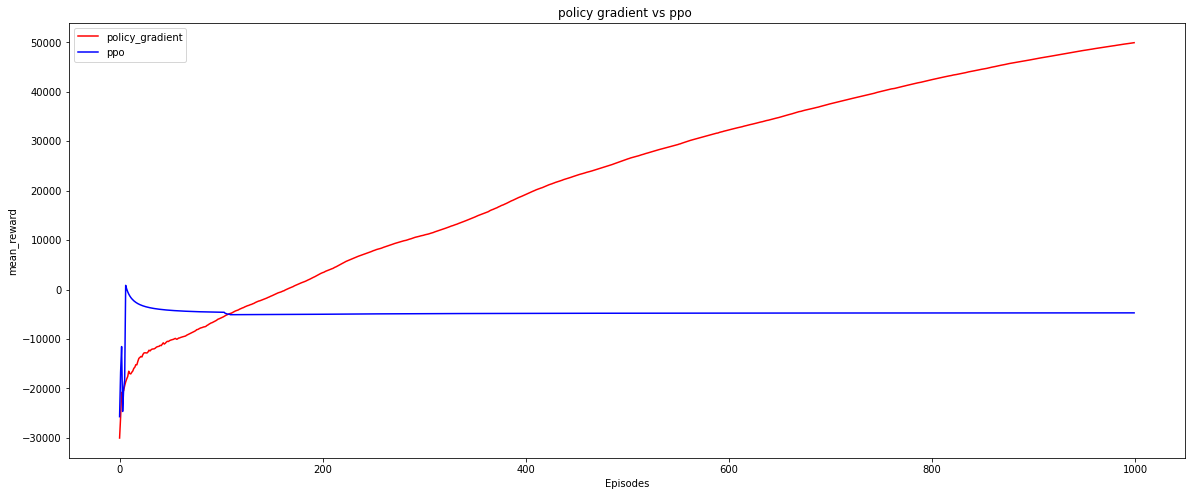

In [45]:
plott(np.mean(np.array(n_rewards),axis =0), running_avg,'policy gradient vs ppo ')

In [ ]:
checkpoint_name = "my_checkpoint_ppo.pth.tar"
path = F"/content/drive/My Drive/{checkpoint_name}" 
save_variable = 'n_rewards'
rewards_highway = load_checkpoint(torch.load(path),save_variable)

In [ ]:
#done = False
images = []  
state = env.reset()
env.render()
observation = env.observation(state)
#images.append(img)
max_step = 50
max_step = 0
while True:
    print("step :" ,max_step)
    input = env.observation(state)
    probs = model(torch.tensor(state.flatten()).unsqueeze(0).float())
    # sample an action from that set of probs
    sampler = Categorical(probs)
    action = sampler.sample()
    new_state, reward, done = env.step(state,action.item()) #next_state, reward, end_state
    env.render()
    max_step +=1
    if max_step>=500:
      break
    state = new_state


In [ ]:
state = env.reset()
        observation = env.observation(state)
        #observation = env.reset
        step_num = 0
        done = False
        score = 0
        while not done:
           
            action, prob, val = agent.choose_action(observation)
            #observation_, reward, done, info = env.step(action)
            #new_state, reward, done = env.step(state,action.item()) ours
            state_, reward, done = env.step(state, action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation_ = env.observation(state_)
            state = state_
            observation = observation_
            
            step_num += 1
            if step_num>500:
                break

In [ ]:

#plot_learning_curve(x, score_history, figure_file)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)

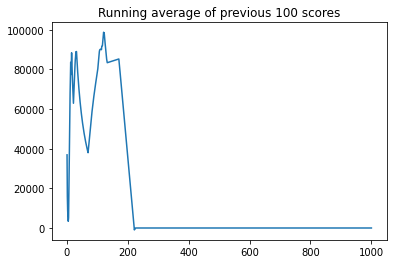

In [ ]:
plot_learning_curve(x, score_history)